# PREDICTION OF THE FLOW OF PEOPLE AT STATIONS

This project aims to predict the flow of people at the principal stations of the NYC Subway. 

# 0 - IMPORTS

In [1]:
import pandas         as pd
import numpy          as np
import datetime       as dt
import seaborn        as sns
import datetime       as dt
import random         as rdm
import xgboost        as xgb

from IPython.core.display      import HTML
from IPython.display           import Image
from boruta                    import BorutaPy

from sklearn.metrics           import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble          import IsolationForest, RandomForestRegressor
from sklearn.preprocessing     import LabelEncoder, MinMaxScaler
from sklearn.linear_model      import LinearRegression, Lasso

from scipy                     import stats       as ss

## 0.1 - Helper functions

In [2]:
# Suppression of the scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Graph sets
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        1
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'flow'], axis=1 )
        ytraining = training['flow']
        
        # validation
        xvalidation = validation.drop( ['date', 'flow'], axis=1 )
        yvalidation = validation['flow']
        
        # model
        m = model.fit( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

Populating the interactive namespace from numpy and matplotlib


## 0.2 - Loading data

Eight CSV files were provided to develop this project. Each one describes data from a specific year ranging from 2010 to 2017. Only the last three years will be considered (2015, 2016 and 2017). Excluding the others years is advantage because a smaller data will be used. The 8-year period is too long, so the last 3 years are the most important as they best represents the current reality of the stations.

In [8]:
# Loading the 3 csv files
df_15 = pd.read_csv('dataset/2015.csv')
df_16 = pd.read_csv('dataset/2016.csv')
df_17 = pd.read_csv('dataset/2017.csv')

# Concatenating the data
df = pd.concat([df_15, df_16, df_17], ignore_index=True)

## 0.3 - Pre-setting of the dataset

In [9]:
# Creating the 'turnstile' column
df['turnstile'] = df['division'] + '_' + df['station'] + '_' + df['linename'] + '_' + df['unit'] + '_' + df['ca'] + '_' + df['scp']

# Replacing the station and turnstiles values with numbers
## station
id_station = df.copy()
id_station = id_station.drop_duplicates(subset='station', keep='first')['station'].reset_index().reset_index()
id_station = id_station.drop('index', axis=1)
id_station.columns = ['id_station', 'station']

df = pd.merge(df, id_station, how='left', on='station')

## turnstile
id_turnstile = df.copy()
id_turnstile = id_turnstile.drop_duplicates(subset='turnstile', keep='first')['turnstile'].reset_index().reset_index()
id_turnstile = id_turnstile.drop('index', axis=1)
id_turnstile.columns = ['id_turnstile', 'turnstile']

df = pd.merge(df, id_turnstile, how='left', on='turnstile')

df = df.drop(['station', 'turnstile'], axis=1).rename(columns={'id_station': 'station', 'id_turnstile': 'turnstile'}) # Dropping the old columns and renaming

## 0.4 - Response variable construction

The turnstiles have cumulatives values of 'entries' and 'exits' so it's necessary to organize the data to get the records of the same turnstile followed by the date and time. In this way it will be possible to calculate the difference between the records and obtain the flow of people through the sations.

In [10]:
df_aux1 = df.copy()
del df

### 0.4.1 - Calculating the difference between the turnstiles records

In [11]:
# Organizing the dataset by hierarchy
df_aux1 = df_aux1.sort_values(['turnstile', 'time']).reset_index(drop=True)
df_aux2 = df_aux1.groupby('turnstile')

# Calculating the difference between the turnstiles records
df_aux1['entries'] = df_aux2['entries'].transform(pd.Series.diff)
df_aux1['exits'] = df_aux2['exits'].transform(pd.Series.diff)

### 0.4.2 - Checking the values post transformation

In [12]:
# Checking the transformed values
print('Number of negative entries values: {}' .format(len(df_aux1['entries'][df_aux1['entries']<0])))
print('Number of negative exits values: {}' .format(len(df_aux1['exits'][df_aux1['exits']<0])))
print('Number of turnstiles: {}' .format(len(df_aux1['turnstile'].unique())))
print('Number of NaN rows: {}' .format(len(df_aux1[df_aux1['entries'].isnull()])))
print('Number of total rows: {}' .format(len(df_aux1['entries'])))

Number of negative entries values: 156407
Number of negative exits values: 114473
Number of turnstiles: 7373
Number of NaN rows: 7373
Number of total rows: 27652130


In [13]:
# Checking the distribution of the values of entries and exits
print('Distribution of the entries:\n{}' .format(df_aux1['entries'].describe()))
print('\nDistribution of the exits:\n{}' .format(df_aux1['exits'].describe()))

Distribution of the entries:
count      27644757.000
mean           3048.444
std         3283317.536
min     -2147369278.000
25%              10.000
50%              77.000
75%             246.000
max      2122355003.000
Name: entries, dtype: float64

Distribution of the exits:
count      27644757.000
mean           2671.289
std         3095444.710
min     -2097169658.000
25%               8.000
50%              52.000
75%             165.000
max      2088918777.000
Name: exits, dtype: float64


### 0.4.3 - Removing problems caused by transformation

**COMMENT:** There are outliers in the dataset as could see comparing the third quartile to the max value, so they will be set to 0 ( > 6000). The negative values happen due the bad record moment by the turnstile. They represent 0.49% of the dataset rows, do they will be set to 0. The NaN values means the intial record of the turnstile, so they will be set to 0.

In [14]:
# Eliminating the problem rows of the dataset
df_aux1[df_aux1['entries'] < 0] = 0
df_aux1['entries'] = df_aux1['entries'].fillna(0)
df_aux1[df_aux1['entries'] > 6000] = 0 # Removing outliers

df_aux1[df_aux1['exits'] < 0] = 0
df_aux1['exits'] = df_aux1['exits'].fillna(0)
df_aux1[df_aux1['exits'] > 6000] = 0 # Removing outliers

### 0.4.4 - Creation of the variable response: 'flow'

In [15]:
# Creation of the 'flow' column
df_aux1['flow'] = df_aux1['entries'] + df_aux1['exits']

# Drop 'entries' and 'exits' columns
df_aux1 = df_aux1.drop(['entries', 'exits'], axis=1)

## 0.5 - Final dataset adjustment

In [16]:
df = df_aux1.copy()

### 0.5.1 - Getting 'date' column and grouping data by date

In [17]:
# Split 'time' column into 'date' and 'time'
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date

# Drop columns
df = df.drop(['time', 'scp', 'desc'], axis=1)

# Grouping the dataset by 'date'
df = df[['ca', 'unit', 'linename', 'division', 'station', 'turnstile', 'date', 'flow']].groupby(['ca', 'unit', 'linename', 'division', 'station','turnstile', 'date']).sum().reset_index()

### 0.5.2 - Identify outliers by IsolationForest

To check the variable response random turnstiles will be selected and observed by graphics. The IsolationForest will be applied as outlier selector method.

In [18]:
# Remove rows with 0 value for 'flow'
df = df[df['flow']>0]

In [ ]:
# Identify outliers by IsolationForest
list_tst = df['turnstile'].unique()
size = len(list_tst)
df_x = df[df['turnstile']==123456789].copy()
iforest = IsolationForest(contamination=0.01)

j = 1
for i in list_tst:
    df_y = df[df['turnstile']==i].copy()

    iforest.fit(df_y[['flow']].values)
    df_y['scores']=iforest.decision_function(df_y[['flow']].values)
    df_y['anomaly']=iforest.predict(df_y[['flow']].values)
    
    mean_ = df_y['flow'].mean()
    if mean_ >= 100:
        df_y['anomaly'] = df_y[['flow', 'anomaly']].apply(lambda x: -2 if (x['flow']<=0.1*mean_) & (x['anomaly']==1) else
                                                                    -1 if (x['anomaly']==-1) else 1, axis=1)
    
    df_x = pd.concat([df_x, df_y])
    print('{} / {}'.format(j, size))
    j = j+1

In [23]:
# Select the three largest to analyze
turnstile = [537, 1526, 3543]

<AxesSubplot:xlabel='date', ylabel='flow'>

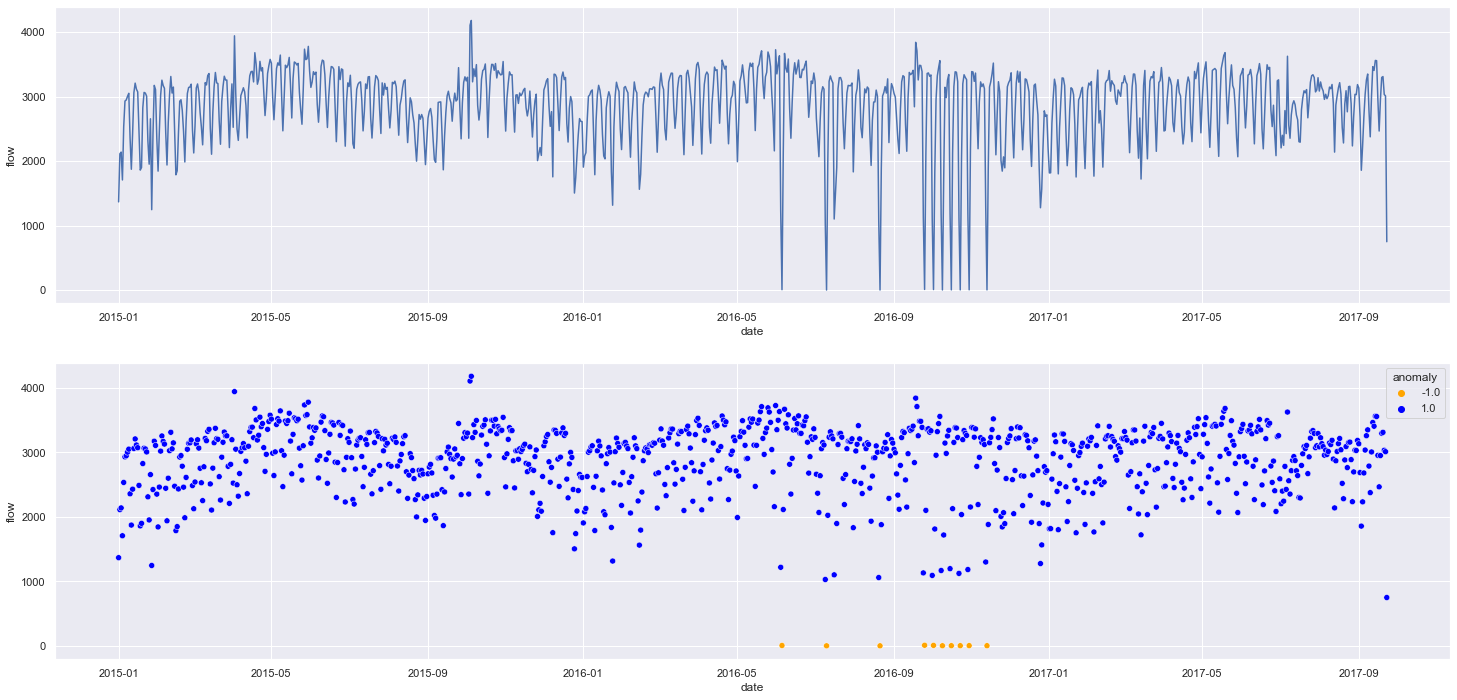

In [24]:
# turnstile 537
subplot(2,1,1)
aux = df[df['turnstile']==537]
sns.lineplot(x='date', y='flow', data=aux)
subplot(2,1,2)
aux1 = df_x[df_x['turnstile']==537]
sns.scatterplot(x='date', y='flow', data=aux1, hue='anomaly', palette=['orange', 'blue'])

<AxesSubplot:xlabel='date', ylabel='flow'>

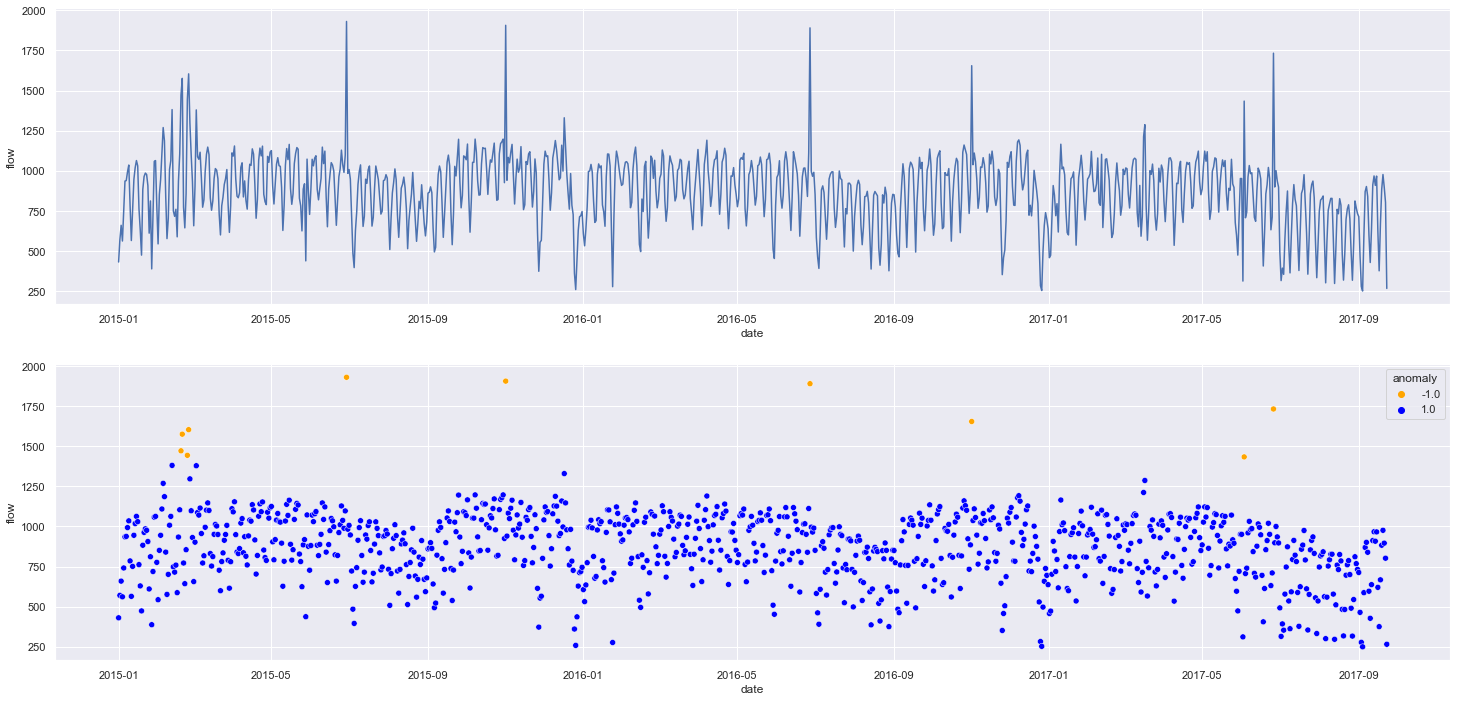

In [25]:
# turnstile 1526
subplot(2,1,1)
aux = df[df['turnstile']==turnstile[1]]
sns.lineplot(x='date', y='flow', data=aux)
subplot(2,1,2)
aux1 = df_x[df_x['turnstile']==turnstile[1]]
sns.scatterplot(x='date', y='flow', data=aux1, hue='anomaly', palette=['orange', 'blue'])

<AxesSubplot:xlabel='date', ylabel='flow'>

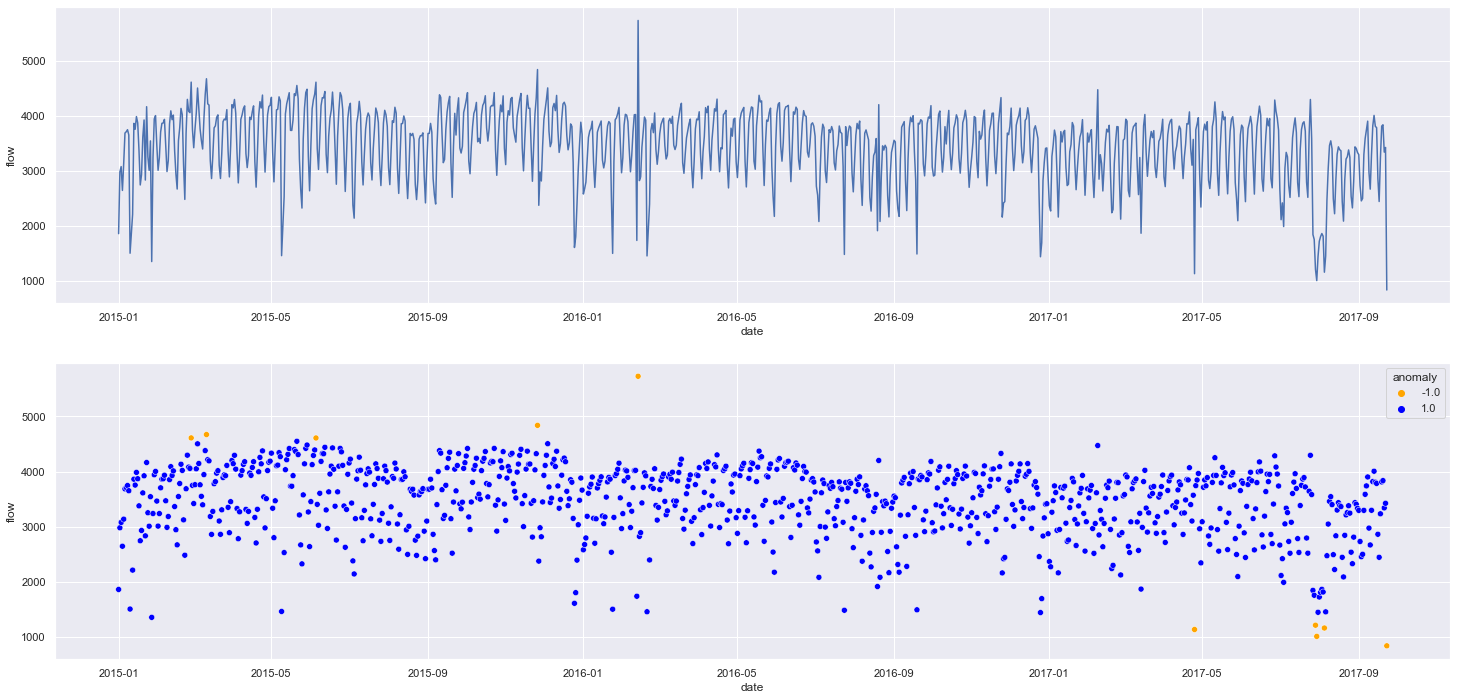

In [26]:
# turnstile 3543
subplot(2,1,1)
aux = df[df['turnstile']==turnstile[2]]
sns.lineplot(x='date', y='flow', data=aux)
subplot(2,1,2)
aux1 = df_x[df_x['turnstile']==turnstile[2]]
sns.scatterplot(x='date', y='flow', data=aux1, hue='anomaly', palette=['orange', 'blue'])

## 0.6 - Exporting the new dataframe to csv

In [27]:
df_x.to_csv('dataset/new_dataset.csv')

## 0.7 - Loading the new dataset

In [3]:
df = pd.read_csv('dataset/new_dataset.csv', low_memory=False)

# 1 - DATA DESCRIPTION

In [4]:
df1 = df.copy()

## 1.1 - Drop columns

In [5]:
df1 = df1.drop(['Unnamed: 0'], axis=1)

## 1.2 - Data dimensions

In [7]:
print('Número de linhas: {}' .format(df1.shape[0]))
print('Número de colunas: {}' .format(df1.shape[1]))

Número de linhas: 4187320
Número de colunas: 10


## 1.3 - Data types

In [6]:
# To datetime
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

ca                   object
unit                 object
linename             object
division             object
station               int64
turnstile             int64
date         datetime64[ns]
flow                float64
scores              float64
anomaly             float64
dtype: object

## 1.4 - Checking NA

In [9]:
df1.isna().sum()

ca           0
unit         0
linename     0
division     0
station      0
turnstile    0
date         0
flow         0
scores       0
anomaly      0
dtype: int64

## 1.5 - Filling NA

There's no NA to fill.

## 1.6 - Descriptive statistics

In [30]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'datetime64[ns]', 'float64'])

In [31]:
# Central tendency - mean and median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew e kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
# Table containing the values above
t = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
t.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
t

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,station,0.000,570.000,570.000,245.828,222.000,168.421,0.315,-1.197
1,turnstile,0.000,7371.000,7371.000,3422.792,3422.000,1981.129,0.098,-1.095
2,flow,1.000,18670.000,18669.000,2087.218,1737.000,1655.745,1.363,2.863
3,scores,-0.460,0.458,0.918,0.236,0.245,0.070,-1.223,2.770
4,anomaly,-2.000,1.000,3.000,0.945,1.000,0.375,-6.932,47.553


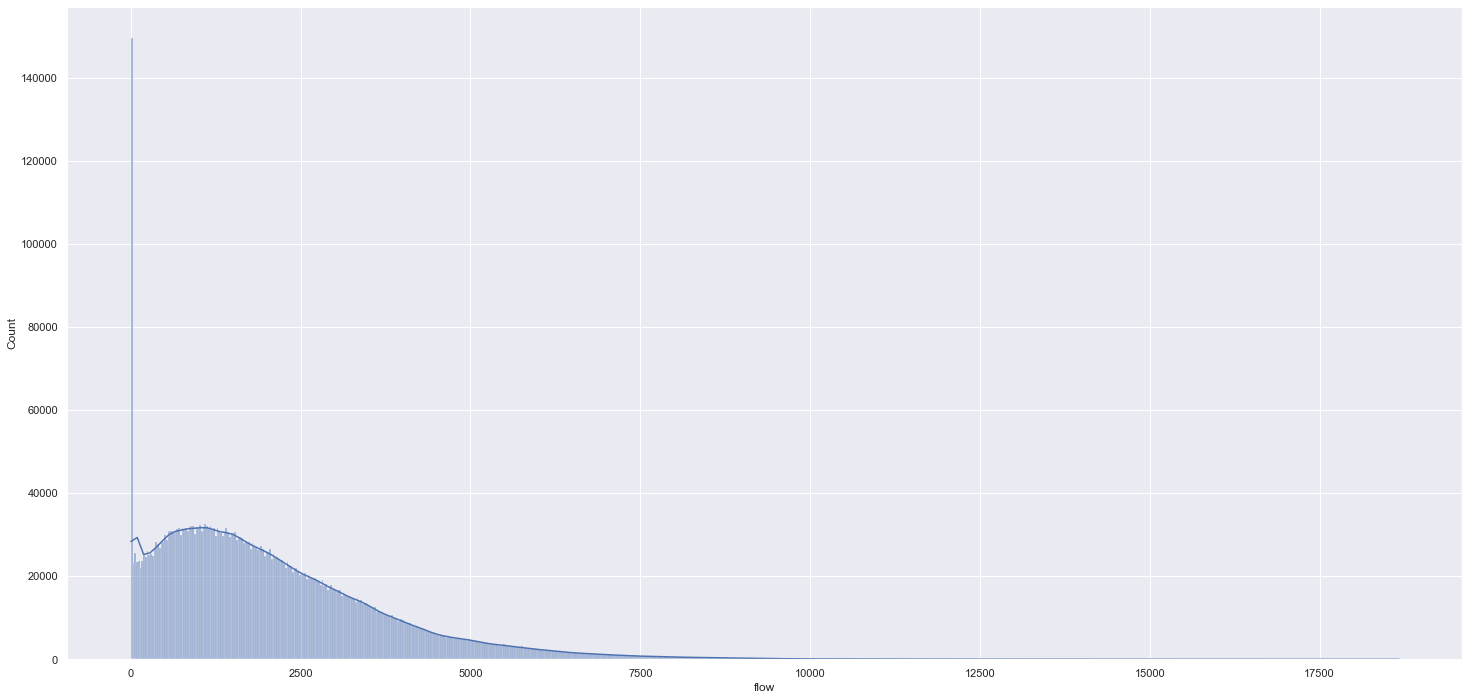

In [12]:
sns.histplot(df1['flow'], kde=True);

### 1.6.2 - Categorical attributes

In [13]:
cat_attributes.apply(lambda x: x.unique().shape[0])

ca          740
unit        470
linename    128
division      6
dtype: int64

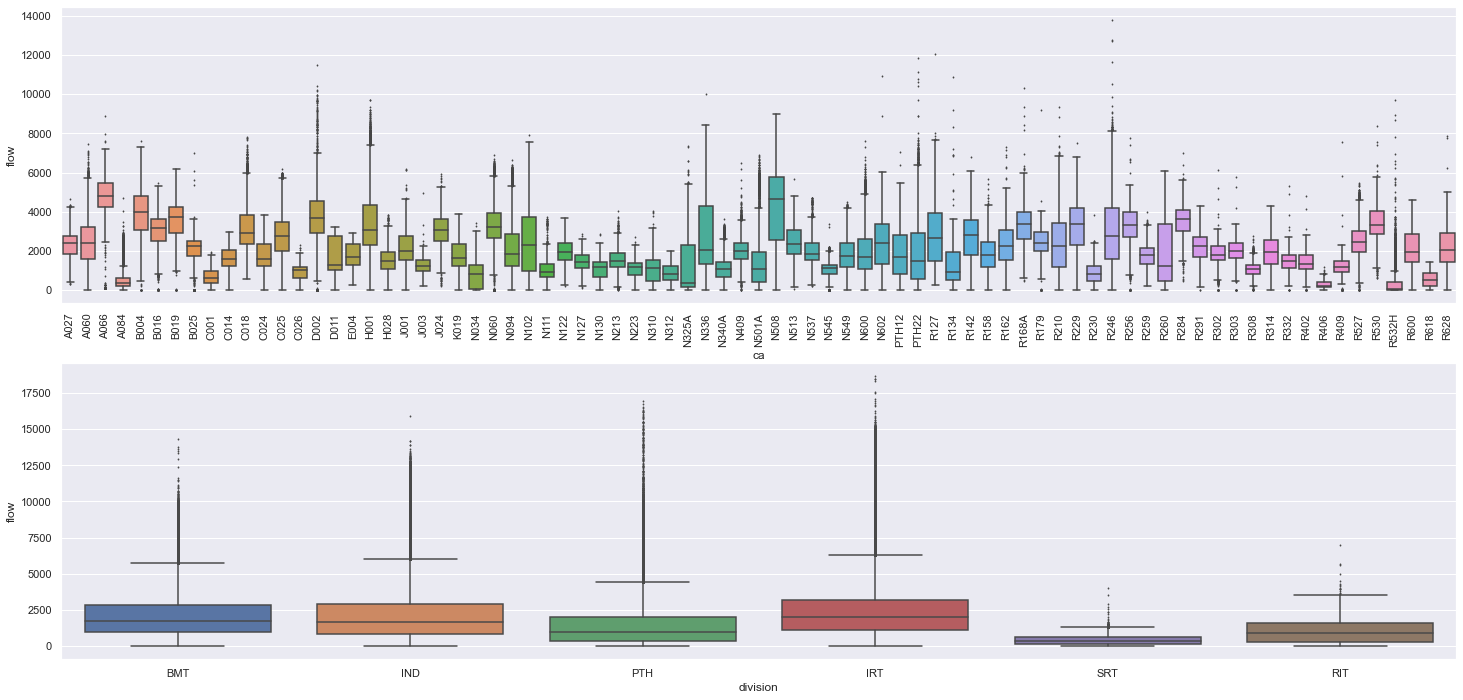

In [38]:
# 'ca'
plt.subplot(2,1,1)
col = 'ca'
list_ = rdm.choices(df1[col].unique(), k=80) # Select some 'ca' values
aux = df1[df1[col].isin(list_)] 
sns.boxplot(x=col, y='flow', data = aux, fliersize=1)
plt.xticks(rotation=90)

# division
plt.subplot(2,1,2)
sns.boxplot(x='division', y='flow', data = df1, fliersize=1);

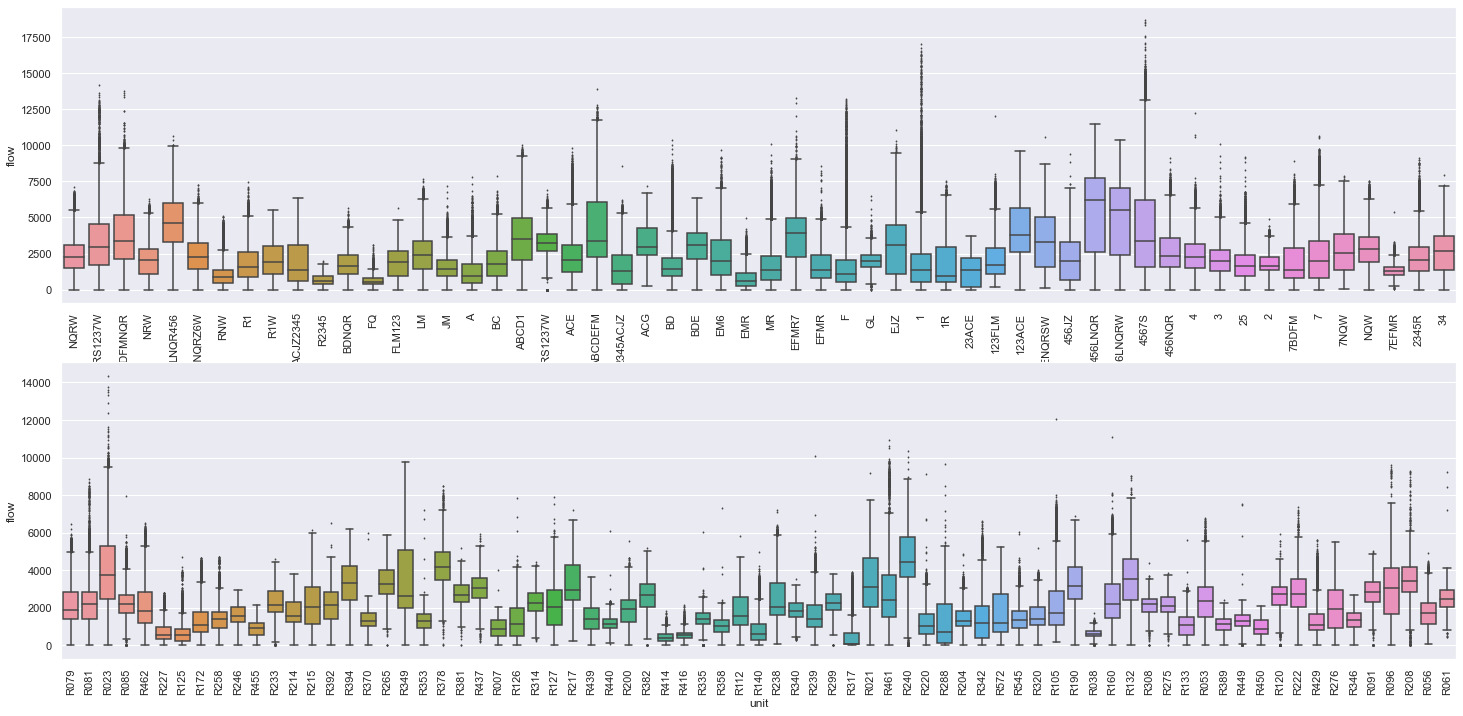

In [40]:
# linename
plt.subplot(2,1,1)
col = 'linename'
list_ = rdm.choices(df1[col].unique(), k=80) # Select some 'ca' values
aux = df1[df1[col].isin(list_)] 
sns.boxplot(x=col, y='flow', data = aux, fliersize=1)
plt.xticks(rotation=90)

# unit
plt.subplot(2,1,2)
col = 'unit'
list_ = rdm.choices(df1[col].unique(), k=80) # Select some 'ca' values
aux = df1[df1[col].isin(list_)] 
sns.boxplot(x=col, y='flow', data = aux, fliersize=1)
plt.xticks(rotation=90);

# 2 - FEATURE ENGINEERING

In [7]:
df2 = df1.copy()

## 2.1 - Hypothesis mind map

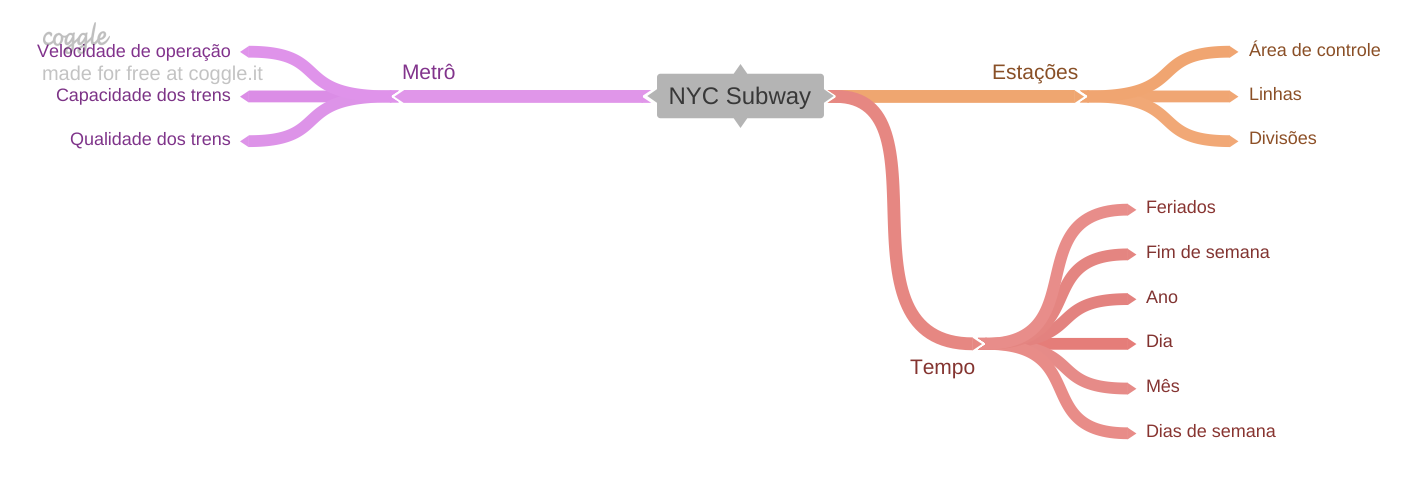

In [8]:
Image('images/NYC_Subway.png')

## 2.2 - Hypothsis creation

### 2.2.1 - Hypothesis of time

**1.** The flow of people on holidays is lower than on regular days.

**2.** The flow of people on weekend is lower than on week days.

**3.** During the winter and the vacation the flow of people on stations is smaller.

**4.** Over the years the flow of people grew on stations.

**5.** Early morning and late afternoon should be rush hours at stations.

### 2.2.2 - Hypothesis of station

**1.** Most stations have high average flow of people (above 2000 people per day).

**2.** Stations with more turnstiles have more flow of people.

**3.** Control areas with more turnstiles have more flow of people.

**4.** Units with more turnstiles have more flow of people.

**5.** Linenames with more turnstiles have more flow of people.

## 2.3 - Final hypothesis

**1.** The flow of people on weekend is lower than on week days.

**2.** During the winter and the vacation the flow of people on stations is smaller.

**3.** Over the years the flow of people grew on stations.

**4.** Most stations have high average flow of people (above 2000 people per day).

**5.** Stations with more turnstiles have more flow of people.

**6.** Control areas with more turnstiles have more flow of people.

**6.** Units with more turnstiles have more flow of people.

**7.** Linenames with more turnstiles have more flow of people.

## 2.4 - Creating and transforming features

In [8]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# month_year
df2['year_month'] = df2['date'].dt.strftime('%Y-%m')

# day_of_week
df2['day_of_week'] = df2['date'].dt.dayofweek

# week_of_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# day_of_year
df2['day_of_year'] = df2['date'].apply(lambda x: x.timetuple().tm_yday)

# summer_vacation
df2['summer_vacation'] = df2[['month', 'day']].apply(lambda x: 1 if ((x['day']>=15)&(x['month']==12)) | (x['month']==1) | (x['month']==2) else
                                                               2 if ((x['day']>=15)&(x['month']==5)) | (x['month']==6) | (x['month']==7) | (x['month']==8) else
                                                               0, axis=1)

# 3 - FILTERING THE DATA

In [9]:
df3 = df2.copy()

## 3.1 - Filtering rows

In [10]:
# Removing 0 value for 'flow'
df3 = df3[df3['flow']>0]

# Removing -1 value for 'anomaly' (the outliers from IsolationForest)
df3 = df3[df3['anomaly']==1]

## 3.2 - Deleting columns

In [11]:
df3 = df3.drop('anomaly', axis=1)

# 4 - EXPLORATORY DATA ANALYSIS

In [12]:
df4 = df3.copy()

## 4.1 Univariate analysis

### 4.1.1 - Response variable

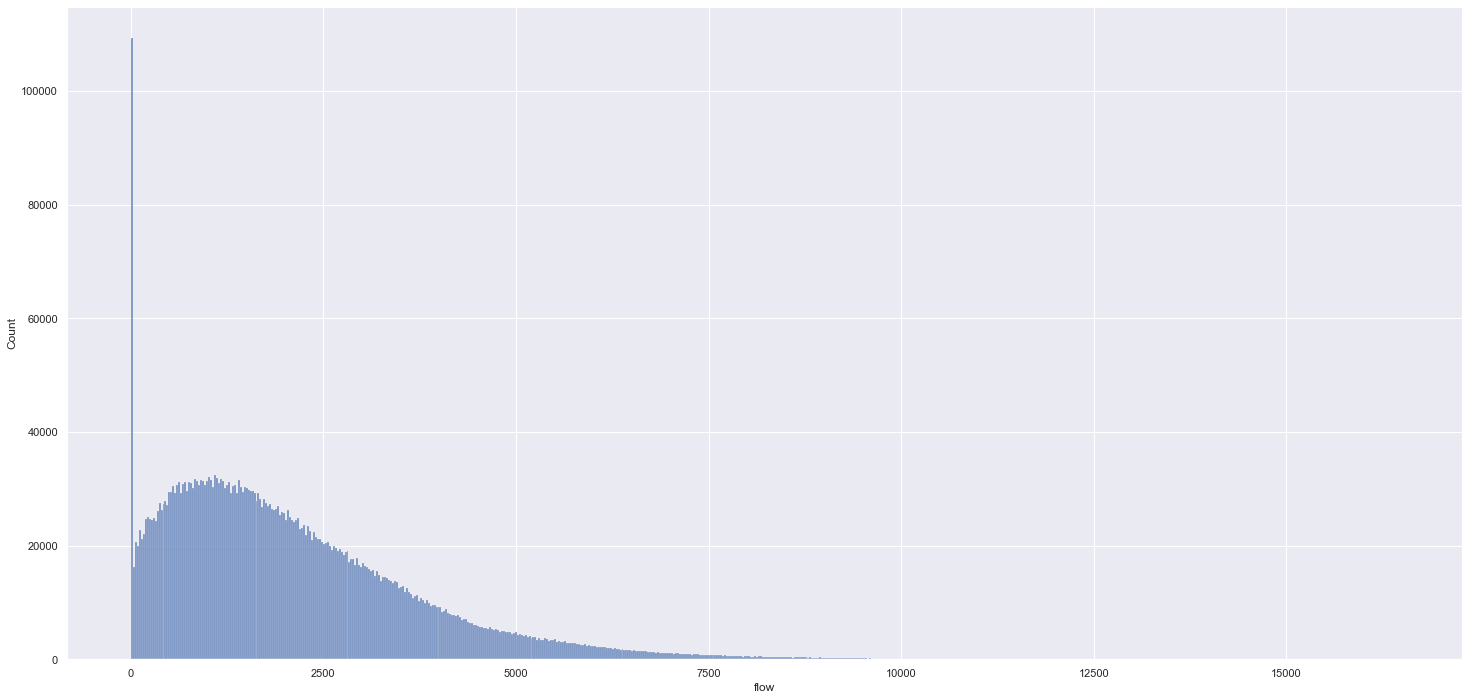

In [12]:
sns.histplot(df4['flow'], kde=False);

### 4.1.2 - Numerical attributes

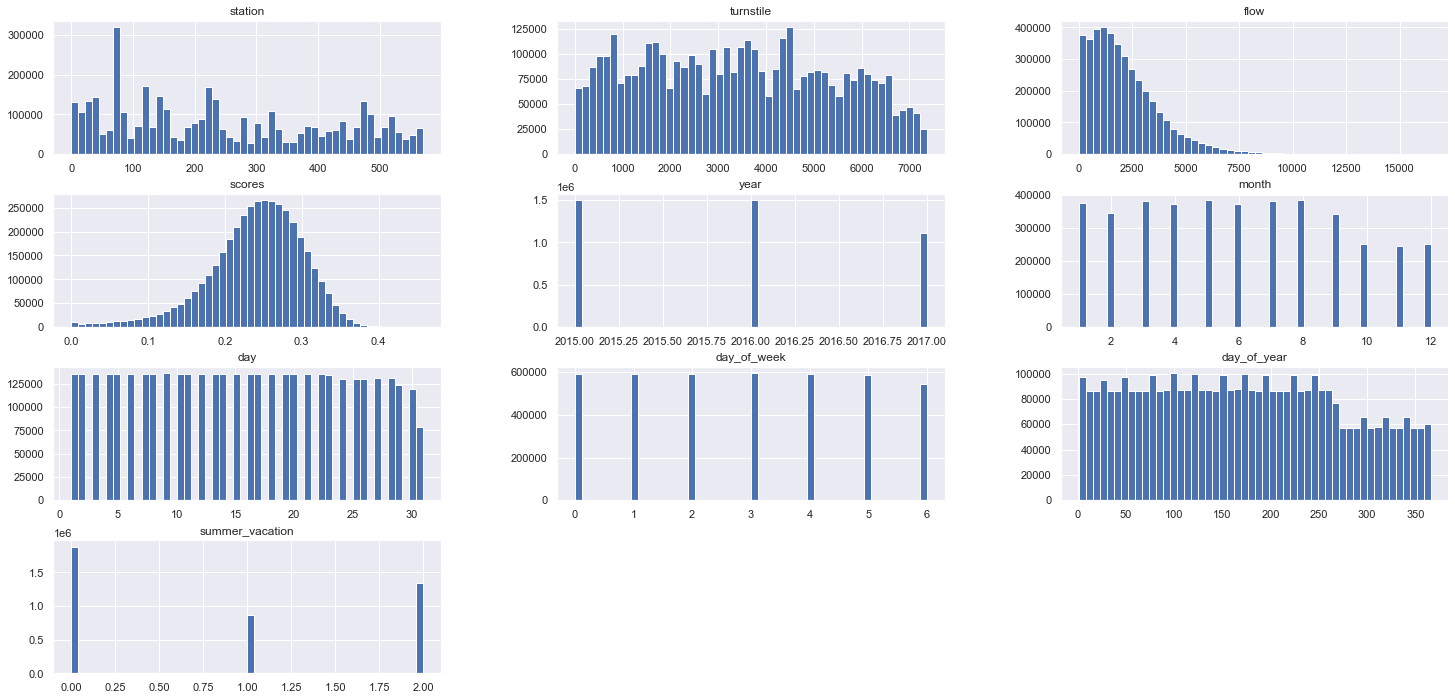

In [38]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
num_attributes.hist(bins=50);

### 4.1.3 - Categorical attributes

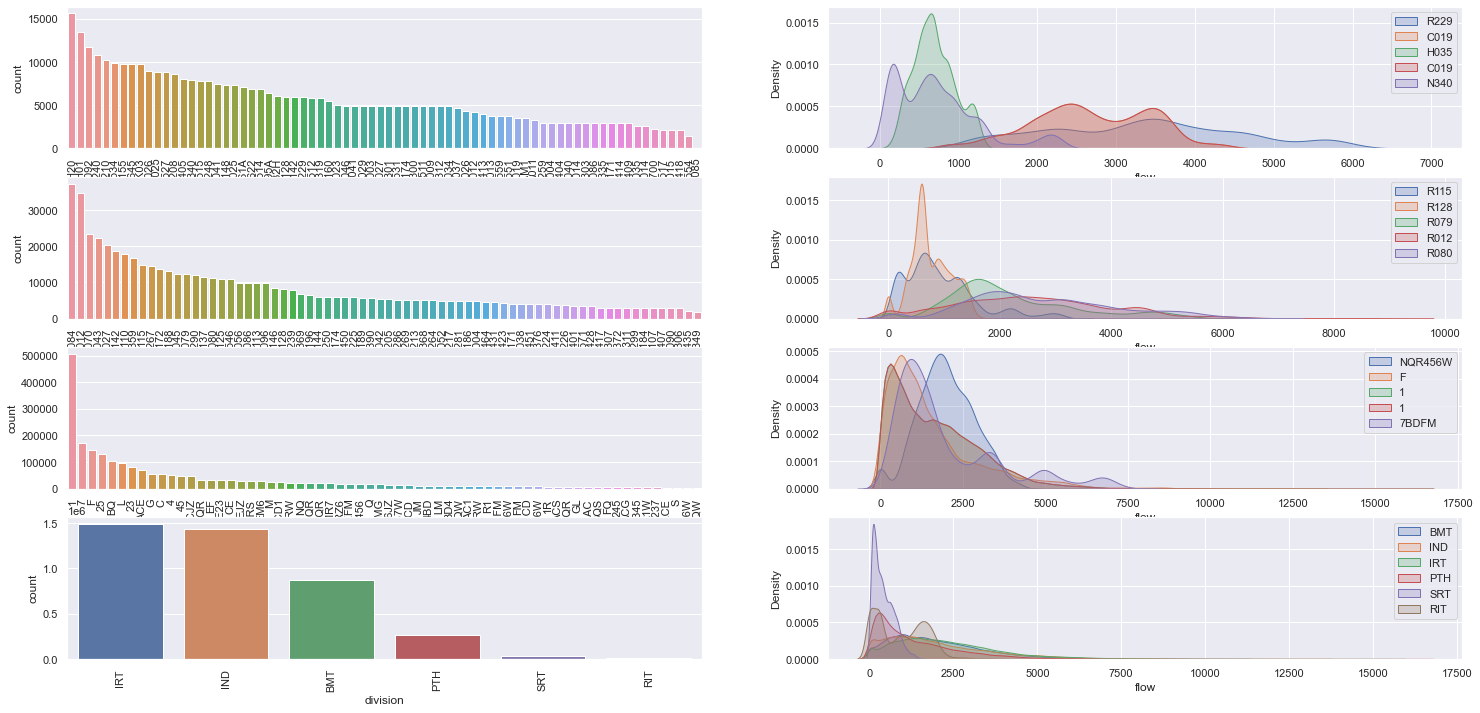

In [26]:
# ca
col = 'ca'
plt.subplot(4,2,1)
a = rdm.choices(df4[col].unique(), k=80) # Select some 'ca' values
aux = df4[df4[col].isin(a)]
sns.countplot(x=col, data=aux, order=aux[col].value_counts().index)
plt.xticks(rotation=90);

plt.subplot(4,2,2)
a = rdm.choices(a, k=5) # Select some 'ca' values
sns.kdeplot(aux[aux[col]==a[0]]['flow'], label=a[0], shade=True)
sns.kdeplot(aux[aux[col]==a[1]]['flow'], label=a[1], shade=True)
sns.kdeplot(aux[aux[col]==a[2]]['flow'], label=a[2], shade=True)
sns.kdeplot(aux[aux[col]==a[3]]['flow'], label=a[3], shade=True)
sns.kdeplot(aux[aux[col]==a[4]]['flow'], label=a[4], shade=True)
plt.legend()

# unit
col = 'unit'
plt.subplot(4,2,3)
a = rdm.choices(df4[col].unique(), k=80) # Select some 'ca' values
aux = df4[df4[col].isin(a)]
sns.countplot(x=col, data=aux, order=aux[col].value_counts().index)
plt.xticks(rotation=90);

plt.subplot(4,2,4)
a = rdm.choices(a, k=5) # Select some 'ca' values
sns.kdeplot(aux[aux[col]==a[0]]['flow'], label=a[0], shade=True)
sns.kdeplot(aux[aux[col]==a[1]]['flow'], label=a[1], shade=True)
sns.kdeplot(aux[aux[col]==a[2]]['flow'], label=a[2], shade=True)
sns.kdeplot(aux[aux[col]==a[3]]['flow'], label=a[3], shade=True)
sns.kdeplot(aux[aux[col]==a[4]]['flow'], label=a[4], shade=True)
plt.legend()

# linename
col = 'linename'
plt.subplot(4,2,5)
a = rdm.choices(df4[col].unique(), k=80) # Select some 'ca' values
aux = df4[df4[col].isin(a)]
sns.countplot(x=col, data=aux, order=aux[col].value_counts().index)
plt.xticks(rotation=90);

plt.subplot(4,2,6)
a = rdm.choices(a, k=5) # Select some 'ca' values
sns.kdeplot(aux[aux[col]==a[0]]['flow'], label=a[0], shade=True)
sns.kdeplot(aux[aux[col]==a[1]]['flow'], label=a[1], shade=True)
sns.kdeplot(aux[aux[col]==a[2]]['flow'], label=a[2], shade=True)
sns.kdeplot(aux[aux[col]==a[3]]['flow'], label=a[3], shade=True)
sns.kdeplot(aux[aux[col]==a[4]]['flow'], label=a[4], shade=True)
plt.legend()

# division
plt.subplot(4,2,7)
sns.countplot(x='division', data=df4, order=df4['division'].value_counts().index)
plt.xticks(rotation=90);

plt.subplot(4,2,8)
sns.kdeplot(df4[df4['division']=='BMT']['flow'], label='BMT', shade=True)
sns.kdeplot(df4[df4['division']=='IND']['flow'], label='IND', shade=True)
sns.kdeplot(df4[df4['division']=='IRT']['flow'], label='IRT', shade=True)
sns.kdeplot(df4[df4['division']=='PTH']['flow'], label='PTH', shade=True)
sns.kdeplot(df4[df4['division']=='SRT']['flow'], label='SRT', shade=True)
sns.kdeplot(df4[df4['division']=='RIT']['flow'], label='RIT', shade=True)
plt.legend();

## 4.2 - Bivariate analysis

### H1: The flow of people on weekend is lower than on week days.

**TRUE** On the weekend the flow of people is smaller.

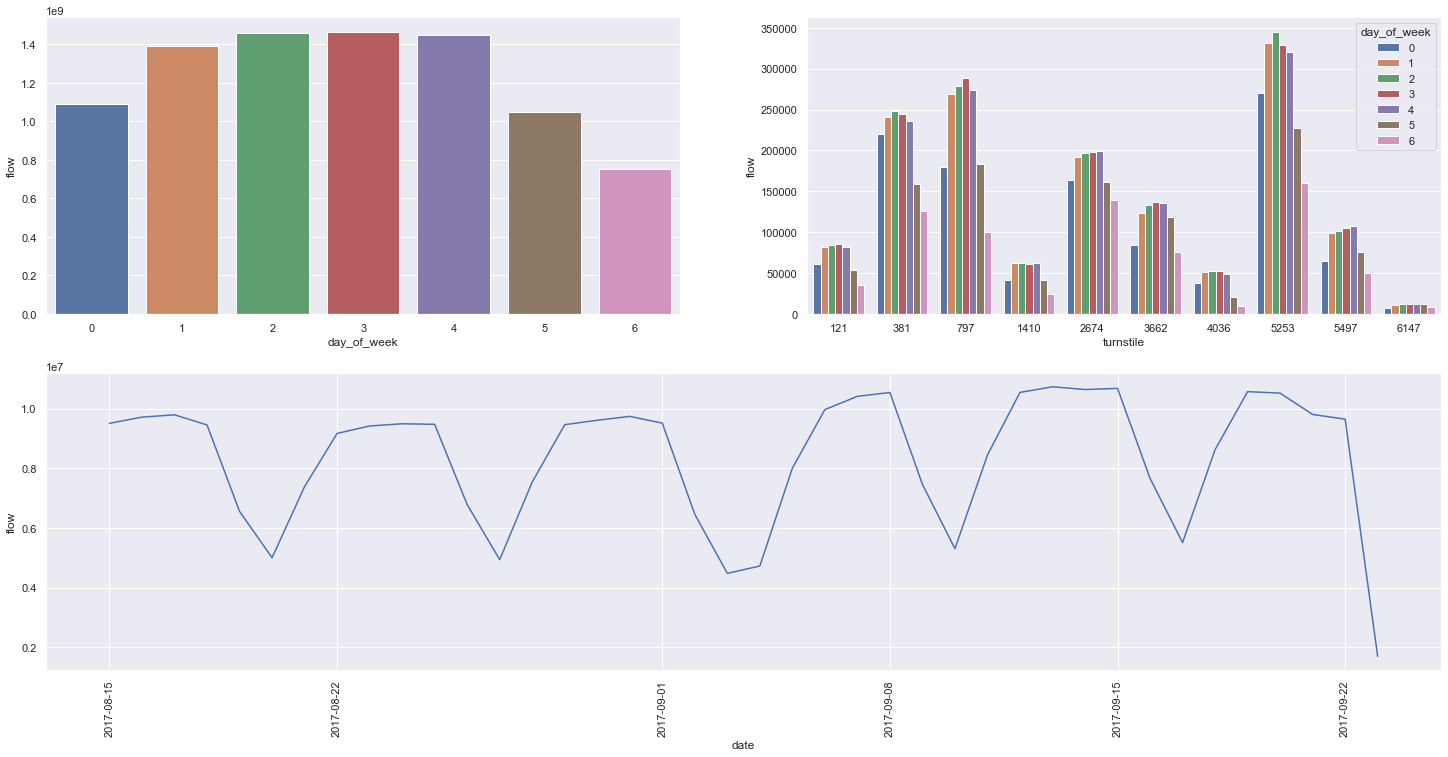

In [44]:
grid = GridSpec(2,2)
plt.subplot(grid[0,0])
aux1 = df4[['day_of_week', 'flow']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y="flow", data=aux1)

plt.subplot(grid[0,1])
aux2 = df4[['day_of_week', 'flow', 'turnstile']].groupby(['turnstile', 'day_of_week']).sum().reset_index()
a = rdm.choices(df4['turnstile'].unique(), k=10)
aux2 = aux2[aux2['turnstile'].isin(a)]
sns.barplot(x='turnstile', y='flow', data=aux2, hue='day_of_week')

plt.subplot(grid[1,:])
aux3 = df4[['date', 'flow']].groupby(['date']).sum().reset_index()
aux3 = aux3[aux3['date']>='2017-08-15']
sns.lineplot(x='date', y='flow', data=aux3)
plt.xticks(rotation=90);

### H2: During the winter the flow of people on stations is smaller.

**TRUE** There is a drop in the flow of people in the last week of year and a considerable reduction in the months of January, February and March.

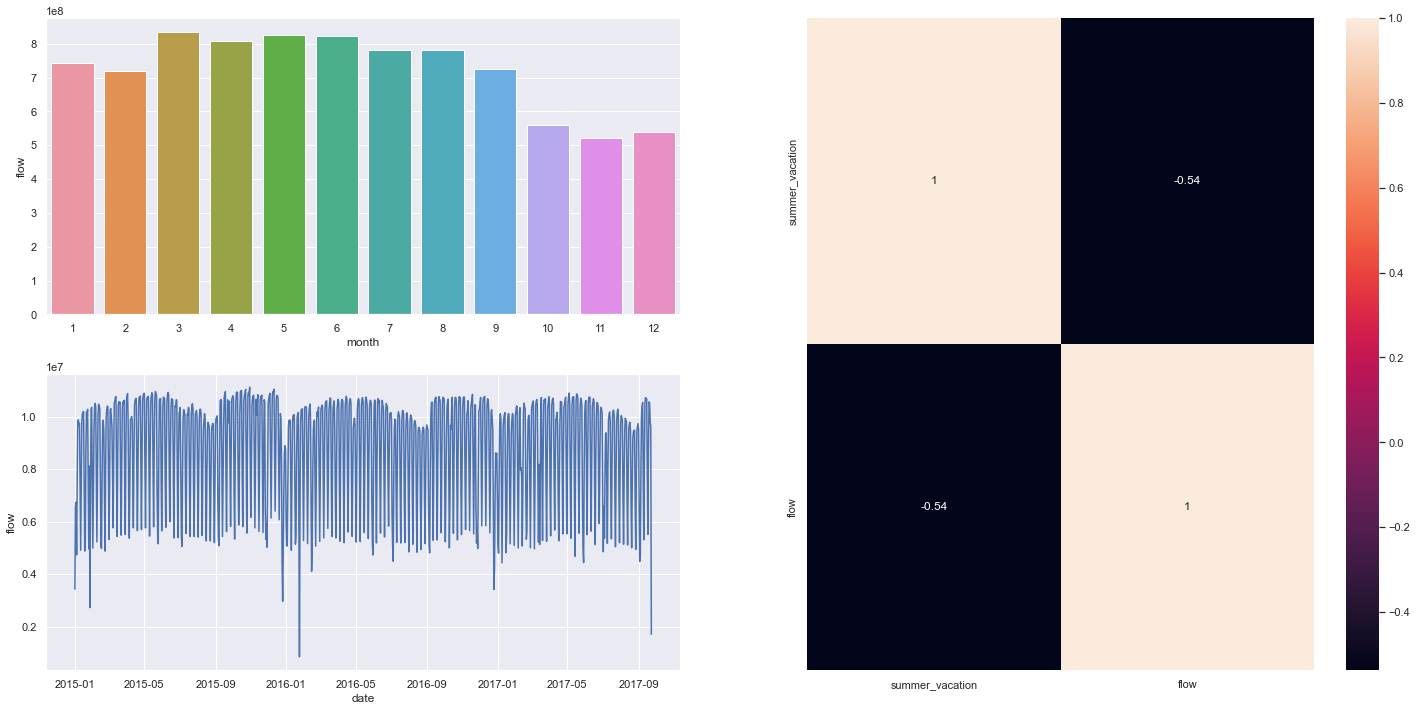

In [64]:
grid = GridSpec(2,2)

plt.subplot(grid[0,0])
aux1 = df4[['month', 'flow']].groupby(['month']).sum().reset_index()
sns.barplot(x='month', y='flow', data=aux1)

plt.subplot(grid[1,0])
aux2 = df4[['date', 'flow']].groupby('date').sum().reset_index()
sns.lineplot(x='date', y='flow', data=aux2)

plt.subplot(grid[:,1])
aux3 = df4[['summer_vacation', 'flow']].groupby(['summer_vacation']).sum().reset_index()
sns.heatmap(aux3.corr(method='pearson'), annot=True);

### H3: Over the years the flow of people grew on stations.

**FALSE** The flow of people has decreased through of the years.

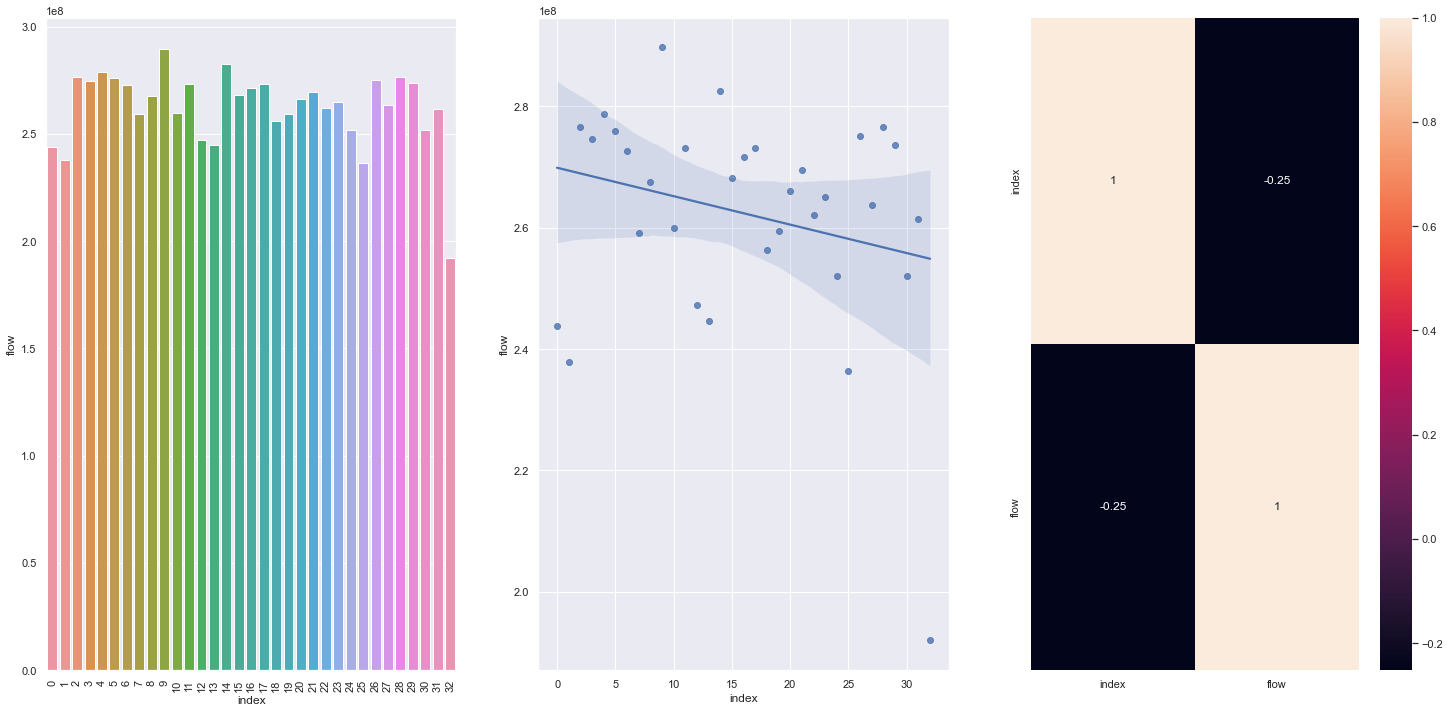

In [73]:
plt.subplot(1,3,1)
aux1 = df4[['year_month', 'flow']].groupby(['year_month']).sum().reset_index().reset_index()
sns.barplot(x='index', y='flow', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(x='index', y='flow', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4: Most stations have high average flow of people (above 2000 people per day).

**FALSE** Most stations have low average flow of people (below 2000 people per day).

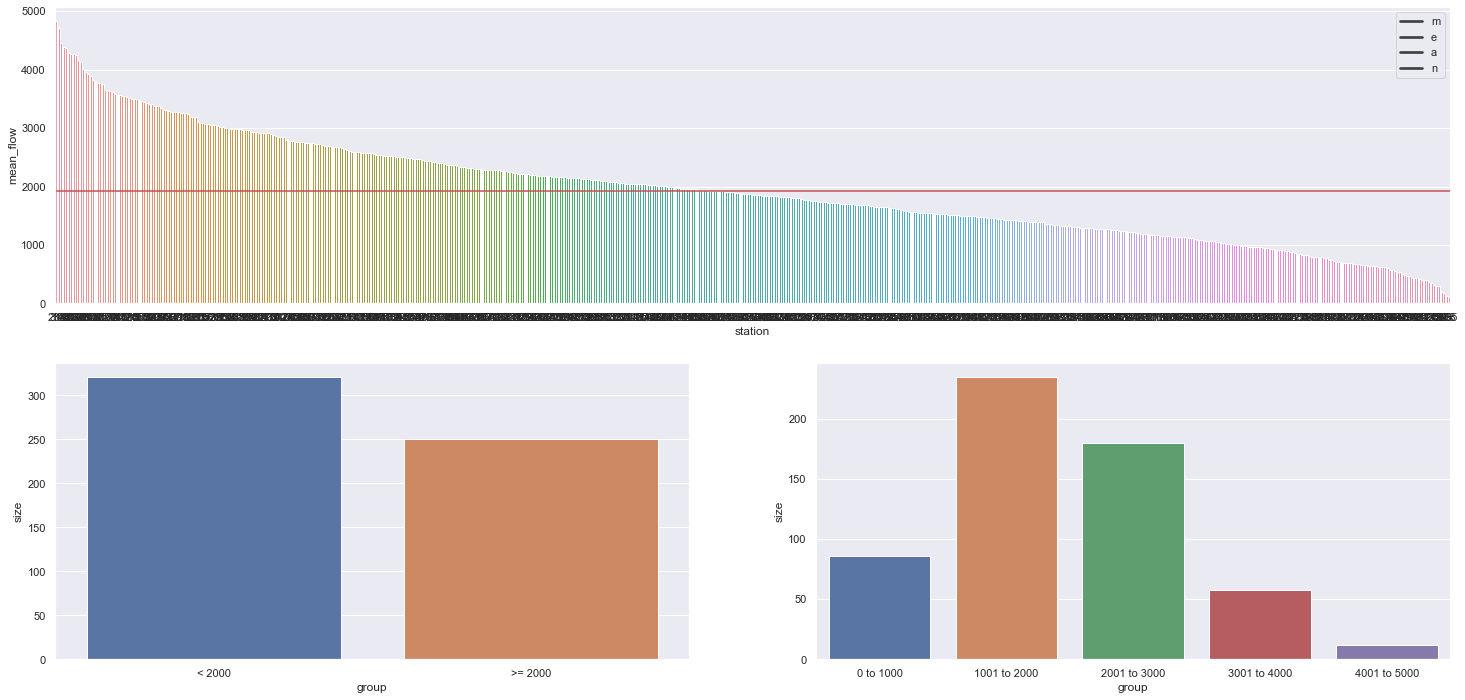

In [101]:
grid = GridSpec(2,2)
aux = df4[['station', 'flow']].groupby('station').mean().reset_index()
aux.columns = ['station', 'mean_flow']

plt.subplot(grid[0,:])
sns.barplot(x='station', y='mean_flow', data=aux, order=aux.sort_values('mean_flow', ascending=False)['station'])
mean_ = aux['mean_flow'].mean()
plt.axhline(y=mean_, color='r', linestyle='-')
plt.legend('mean')

plt.subplot(grid[1,0])
aux['group'] = aux['mean_flow'].apply(lambda x: '>= 2000' if x>=2000 else '< 2000')
aux1 = aux[['station','group']].groupby('group').size().reset_index()
aux1.columns = ['group', 'size']
sns.barplot(x='group', y='size', data=aux1)

plt.subplot(grid[1,1])
aux['group'] = aux['mean_flow'].apply(lambda x: '0 to 1000' if x <= 1000 else 
                                                '1001 to 2000' if (x > 1000)&(x <= 2000) else
                                                '2001 to 3000' if (x > 2000)&(x <= 3000) else
                                                '3001 to 4000' if (x > 3000)&(x <= 4000) else
                                                '4001 to 5000' if (x > 4000)&(x <= 5000) else
                                                '> 5000')
aux1 = aux[['station','group']].groupby('group').size().reset_index()
aux1.columns = ['group', 'size']
sns.barplot(x='group', y='size', data=aux1);

### H5: Stations with more turnstiles have more flow of people.

**TRUE** Stations with more turnstiles have more flow of people.

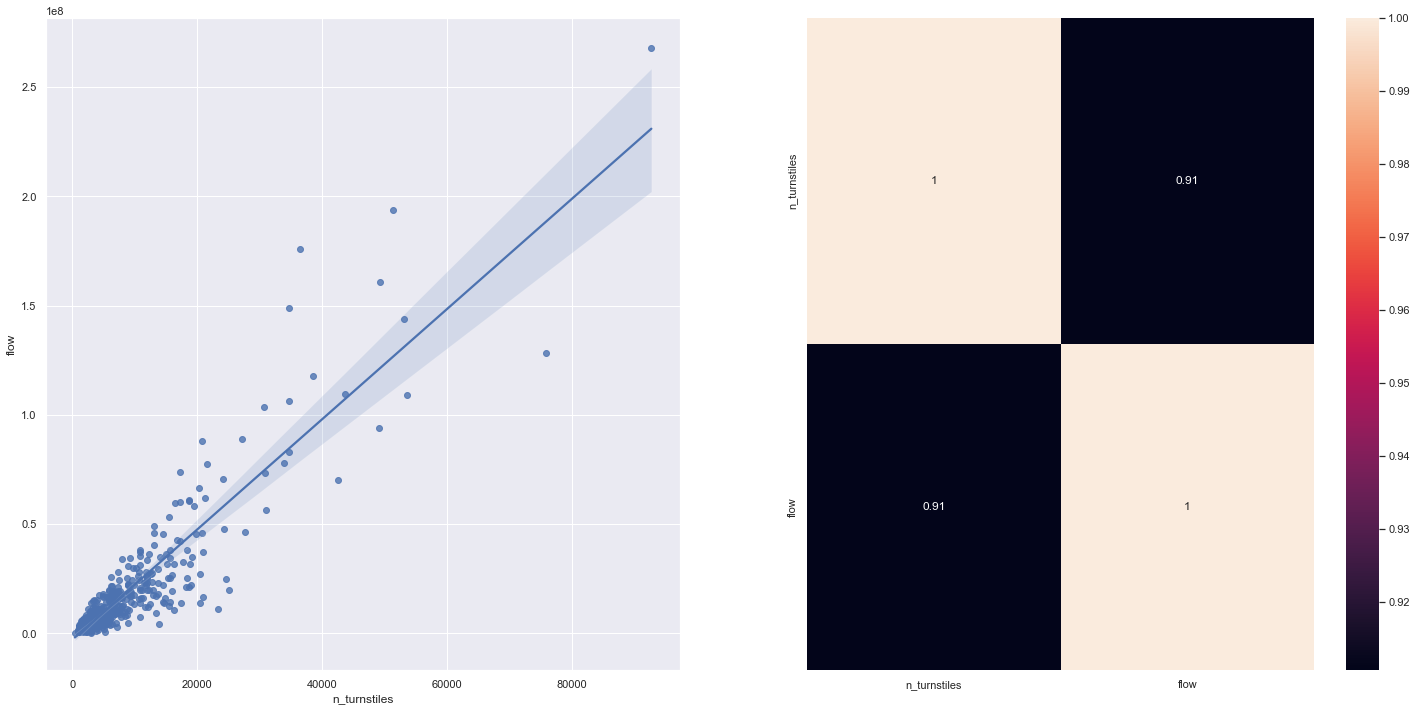

In [107]:
plt.subplot(1,2,1)
aux1 = df4[['station', 'flow']].groupby('station').sum().reset_index()
aux2 = df4[['station', 'turnstile']].groupby('station').size().reset_index()
aux = pd.merge(aux1, aux2, how='left', on='station')
aux.columns = ['station', 'flow', 'n_turnstiles']
sns.regplot(x='n_turnstiles', y='flow', data=aux)

plt.subplot(1,2,2)
aux = aux[['n_turnstiles', 'flow']]
sns.heatmap(aux.corr(method='pearson'), annot=True);

### H6: Control areas with more turnstiles have more flow of people.

**TRUE** Control areas with more turnstiles have more flow of people.

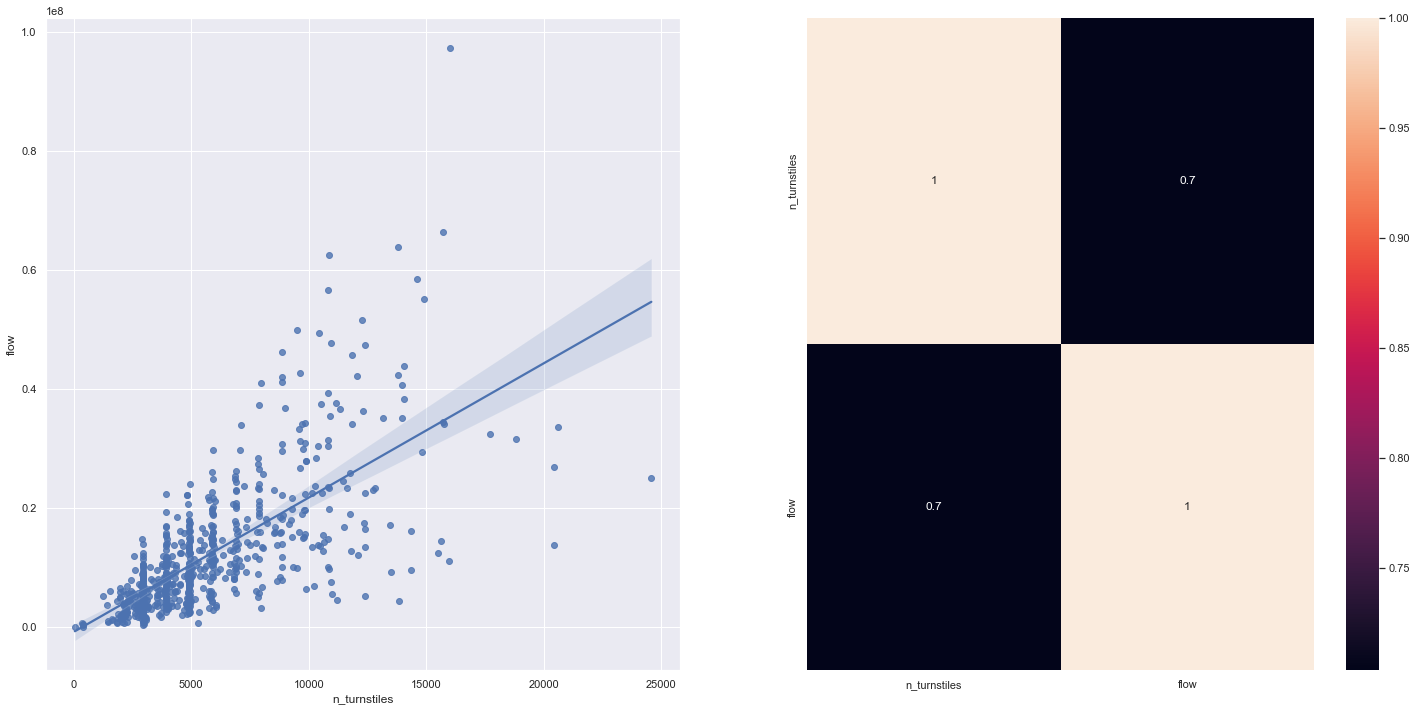

In [14]:
plt.subplot(1,2,1)
aux1 = df4[['ca', 'flow']].groupby('ca').sum().reset_index()
aux2 = df4[['ca', 'turnstile']].groupby('ca').size().reset_index()
aux = pd.merge(aux1, aux2, how='left', on='ca')
aux.columns = ['ca', 'flow', 'n_turnstiles']
sns.regplot(x='n_turnstiles', y='flow', data=aux)

plt.subplot(1,2,2)
aux = aux[['n_turnstiles', 'flow']]
sns.heatmap(aux.corr(method='pearson'), annot=True);

### H7: Units with more turnstiles have more flow of people.

**TRUE** Units with more turnstiles have more flow of people.

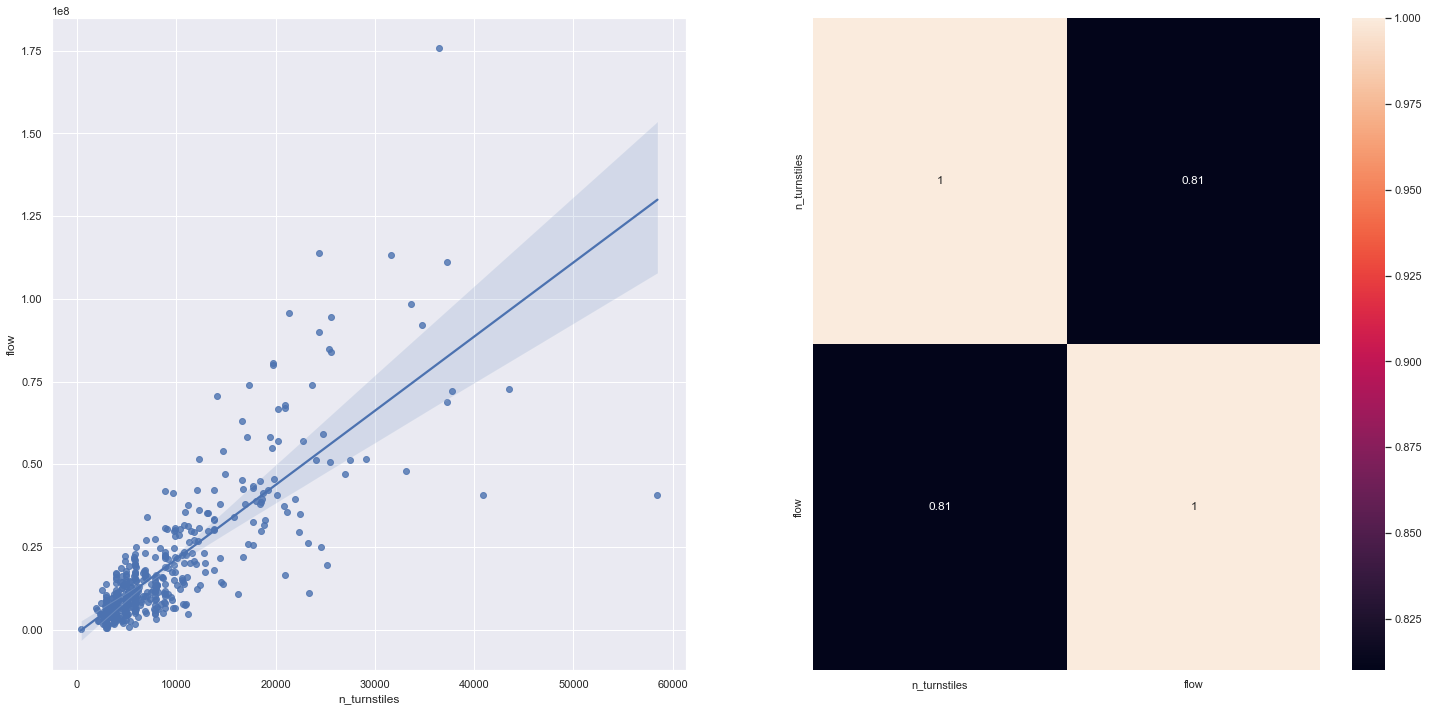

In [15]:
plt.subplot(1,2,1)
aux1 = df4[['unit', 'flow']].groupby('unit').sum().reset_index()
aux2 = df4[['unit', 'turnstile']].groupby('unit').size().reset_index()
aux = pd.merge(aux1, aux2, how='left', on='unit')
aux.columns = ['unit', 'flow', 'n_turnstiles']
sns.regplot(x='n_turnstiles', y='flow', data=aux)

plt.subplot(1,2,2)
aux = aux[['n_turnstiles', 'flow']]
sns.heatmap(aux.corr(method='pearson'), annot=True);

### H8: Linenames with more turnstiles have more flow of people.

**TRUE** Linenames with more turnstiles have more flow of people.

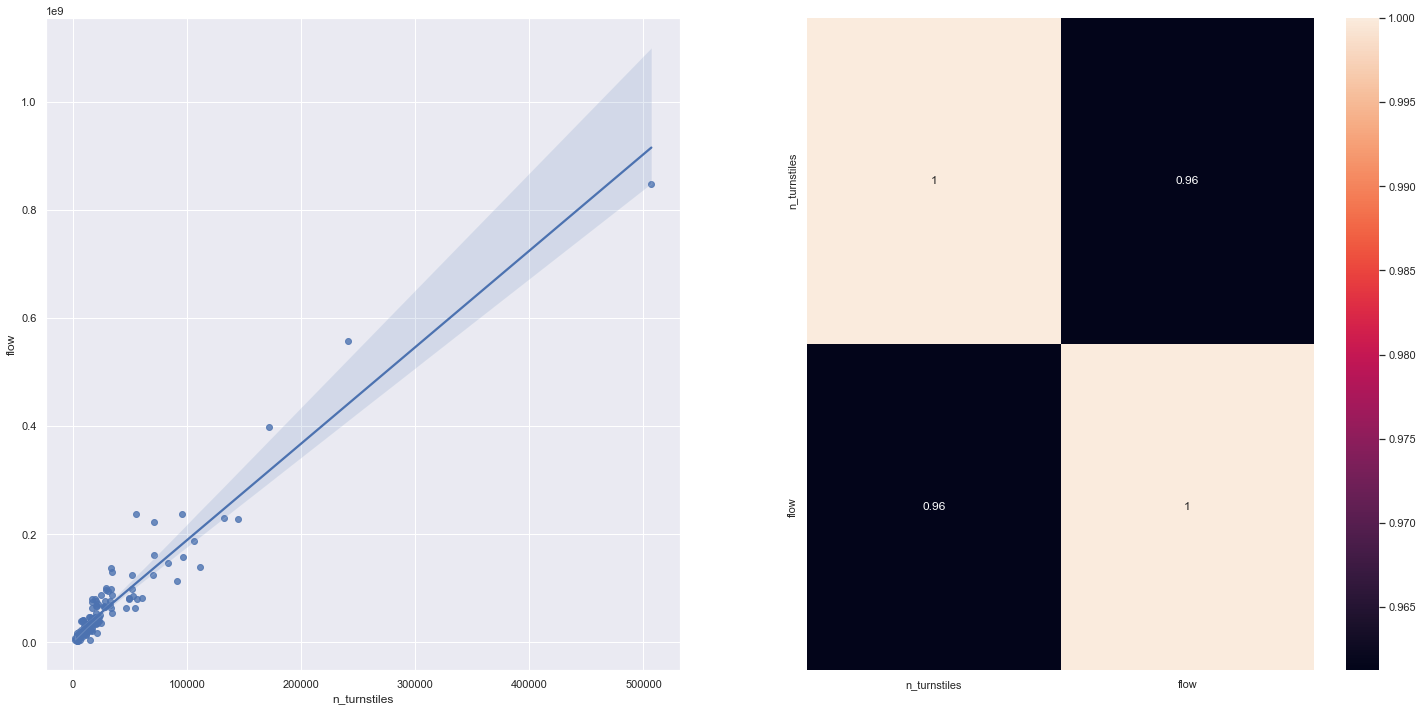

In [19]:
plt.subplot(1,2,1)
aux1 = df4[['linename', 'flow']].groupby('linename').sum().reset_index()
aux2 = df4[['linename', 'turnstile']].groupby('linename').size().reset_index()
aux = pd.merge(aux1, aux2, how='left', on='linename')
aux.columns = ['linename', 'flow', 'n_turnstiles']
sns.regplot(x='n_turnstiles', y='flow', data=aux)

plt.subplot(1,2,2)
aux = aux[['n_turnstiles', 'flow']]
sns.heatmap(aux.corr(method='pearson'), annot=True);

## 4.3 - Multivariated analysis

### 4.3.1 - Numerical attributes

<AxesSubplot:>

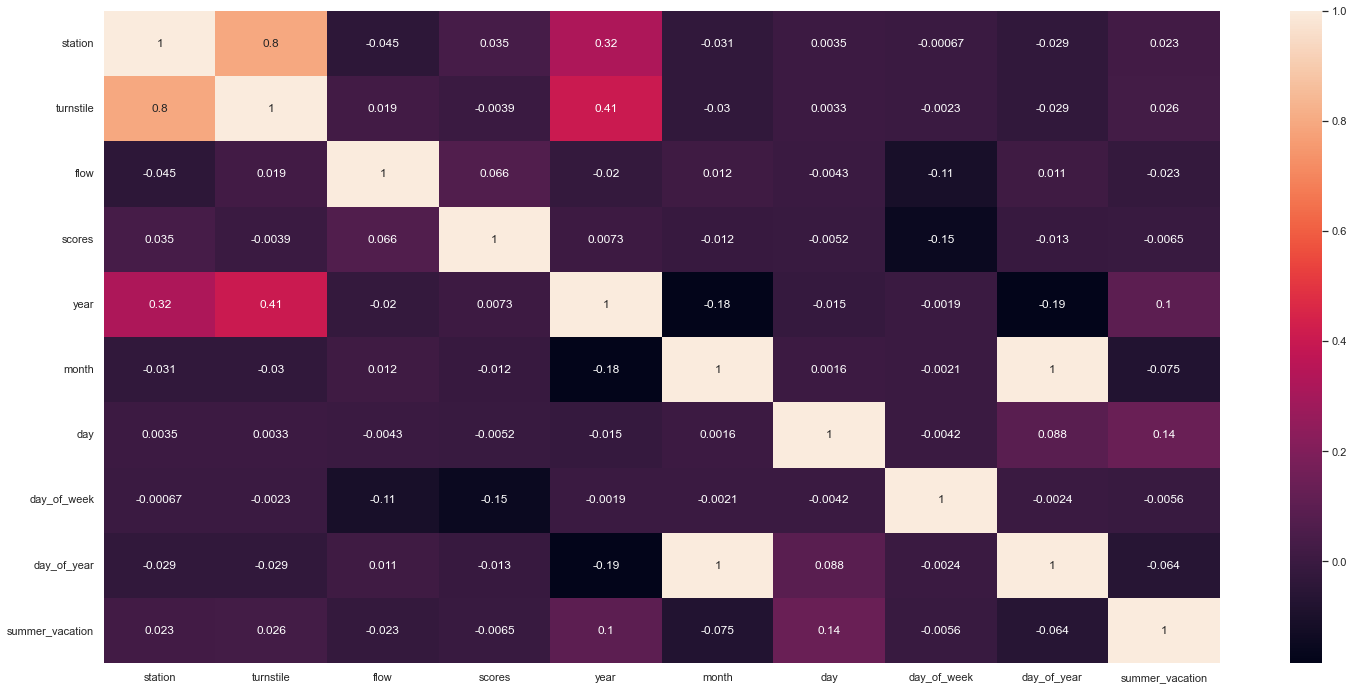

In [39]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 - Categorical attributes

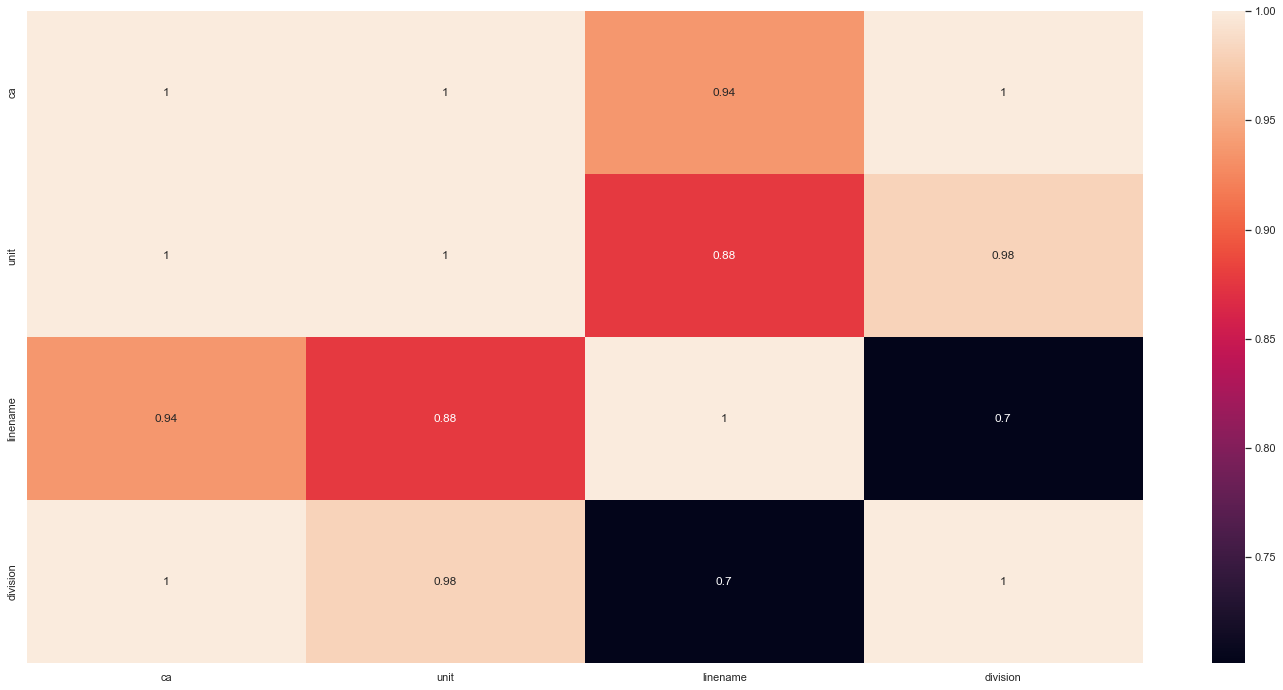

In [24]:
# Somente dados categóricos
a = df4.select_dtypes(include='object')

# Calculando Cramer V
a1 = cramer_v(a['ca'], a['ca'])
a2 = cramer_v(a['ca'], a['unit'])
a3 = cramer_v(a['ca'], a['linename'])
a4 = cramer_v(a['ca'], a['division'])

a5 = cramer_v(a['unit'], a['ca'])
a6 = cramer_v(a['unit'], a['unit'])
a7 = cramer_v(a['unit'], a['linename'])
a8 = cramer_v(a['unit'], a['division'])

a9 = cramer_v(a['linename'], a['ca'])
a10 = cramer_v(a['linename'], a['unit'])
a11 = cramer_v(a['linename'], a['linename'])
a12 = cramer_v(a['linename'], a['division'])

a13 = cramer_v(a['division'], a['ca'])
a14 = cramer_v(a['division'], a['unit'])
a15 = cramer_v(a['division'], a['linename'])
a16 = cramer_v(a['division'], a['division'])

# DataSet final
d = pd.DataFrame({'ca': [a1,a2,a3,a4],
                  'unit': [a5, a6, a7, a8],
                  'linename': [a9, a10, a11, a12],
                  'division': [a13, a14, a15, a16]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5 - DATA PREPARATION

In [13]:
df5 = df4.copy()

## 5.1 - Rescaling

In [14]:
mms = MinMaxScaler(feature_range=(0,1))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.2 - Transformation

### 5.2.1 - Enconding

In [15]:
le = LabelEncoder()

# unit
df5['unit'] = le.fit_transform(df5['unit'])

# ca
df5['ca'] = le.fit_transform(df5['ca'])

# linename
df5['linename'] = le.fit_transform(df5['linename'])

# division
df5['division'] = le.fit_transform(df5['division'])

### 5.2.2 - Transformation of the response variable

In [16]:
df5['flow'] = np.log1p(df5['flow'])

### 5.2.3 - Nature transformation

In [17]:
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# day_of_year
df5['day_of_year_sin'] = df5['day_of_year'].apply(lambda x: np.sin(x*(2*np.pi/365)))
df5['day_of_year_cos'] = df5['day_of_year'].apply(lambda x: np.cos(x*(2*np.pi/365)))

### 5.2.4 - Transformation Data Analysis 

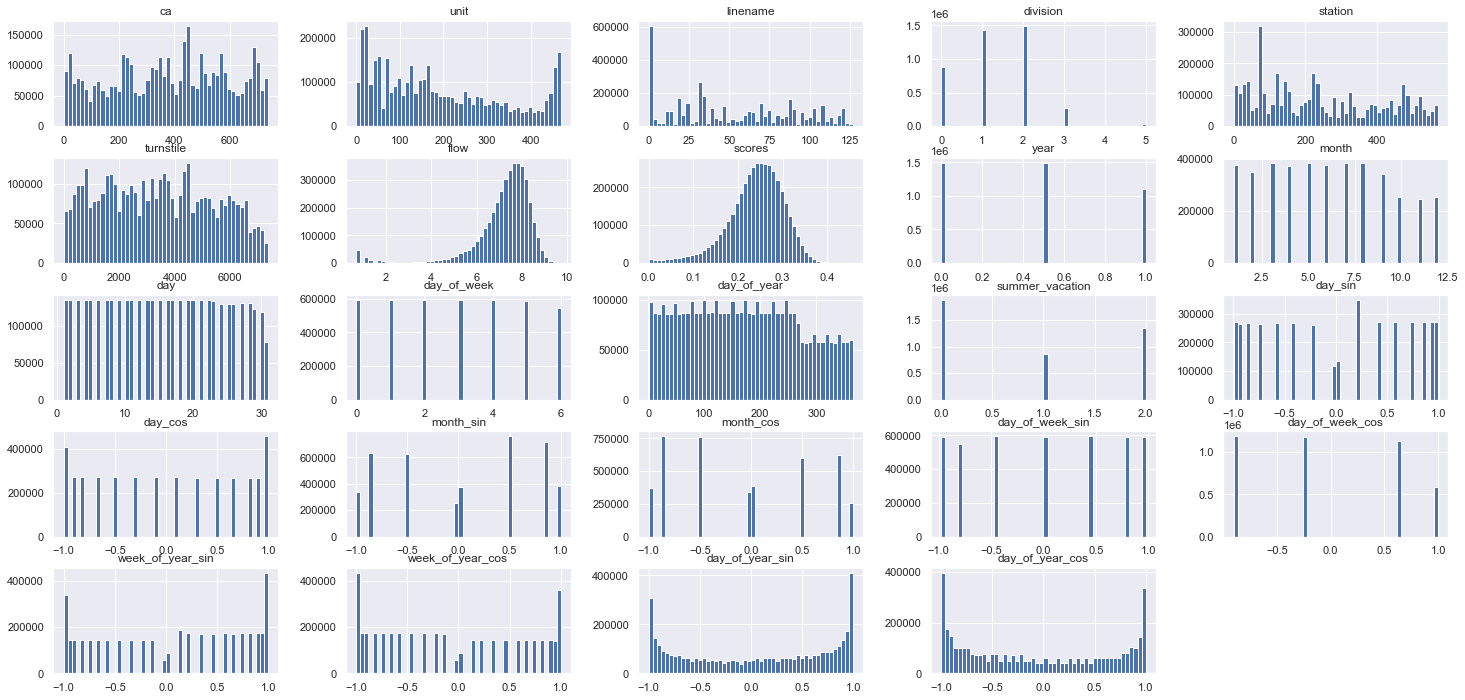

In [45]:
aux = df5.select_dtypes(include=['int64', 'float64', 'int32'])
aux.hist(bins=50);

<AxesSubplot:>

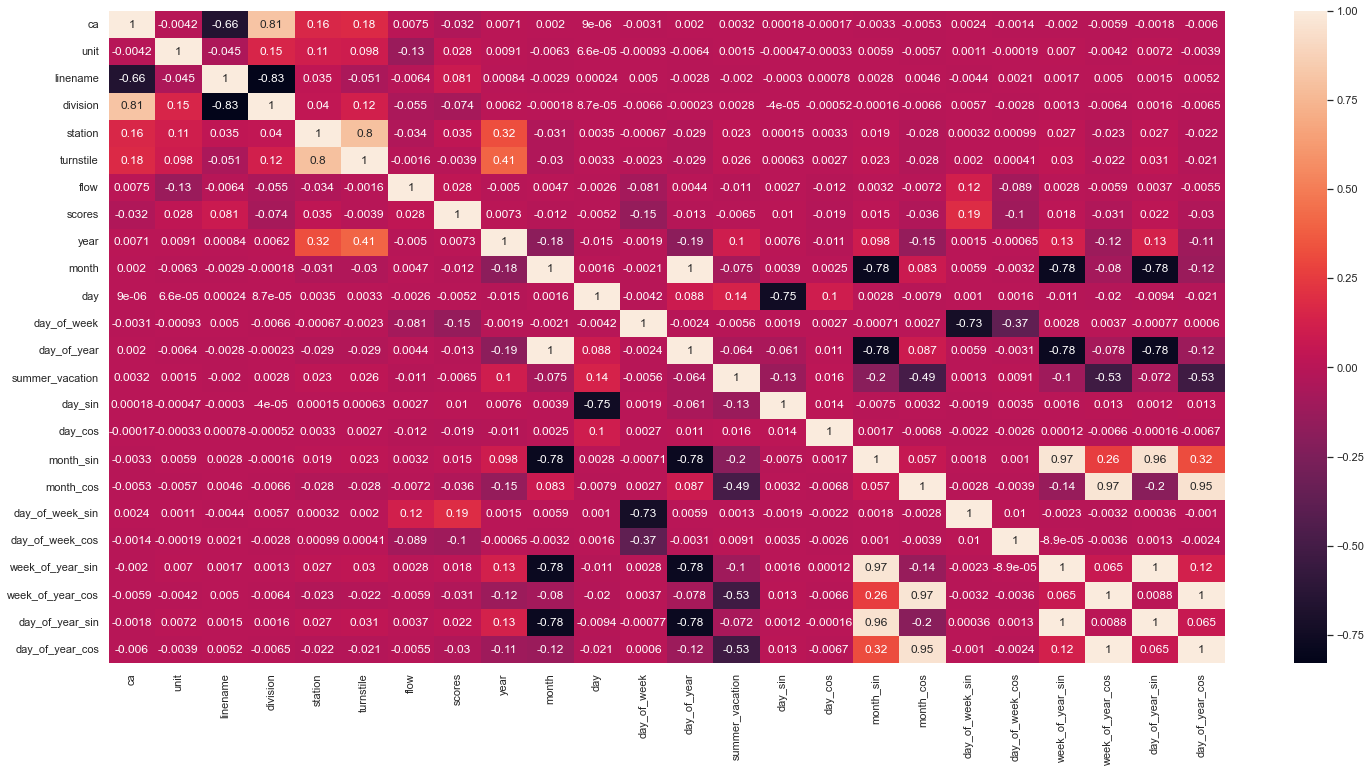

In [46]:
num_attributes = df5.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

# 6 - FEATURE SELECTION

In [18]:
df6 = df5.copy()

## 6.1 - Split dataframe into train and test dataset

In [19]:
cols_drop = ['month', 'day', 'day_of_week', 'year_month', 'day_of_year', 'week_of_year']
df6 = df6.drop(cols_drop, axis=1)

In [20]:
# Train extension dataset
extension = 30
division_date = df6['date'].max() - dt.timedelta(extension)

## Train dataset
X_train = df6[df6['date'] < division_date]
y_train = X_train['flow']
## Test dataset
X_test = df6[df6['date'] >= division_date]
y_test = X_test['flow']

print('Training Min Date: {}' .format(X_train['date'].min()))
print('Training Max Date: {}' .format(X_train['date'].max()))

print('\nTeste Min Date: {}' .format(X_test['date'].min()))
print('Teste Max Date: {}' .format(X_test['date'].max()))

Training Min Date: 2015-01-01 00:00:00
Training Max Date: 2017-08-23 00:00:00

Teste Min Date: 2017-08-24 00:00:00
Teste Max Date: 2017-09-23 00:00:00


## 6.2 - Applying Boruta as Feature Selector

In [27]:
# Train and test dataset for Boruta
X_train_n = X_train.drop(['date', 'flow'], axis=1).values
y_train_n = y_train.values.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# Define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state = 20).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	7


### 6.2.1 - Best features from Boruta

In [28]:
cols_selected = boruta.support_.tolist()

# Best features
X_train_fs = X_train.drop(['date', 'flow'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Features not selected
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 - Manual feature selection

In [29]:
cols_selected_boruta

['ca',
 'unit',
 'linename',
 'division',
 'station',
 'turnstile',
 'scores',
 'year',
 'week_of_year',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_of_year_sin',
 'day_of_year_cos']

In [21]:
cols_selected_boruta = ['division', 'linename', 'unit', 'ca', 'station', 'turnstile', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'day_of_week_sin',
                        'day_of_week_cos', 'day_of_year', 'scores']

cols_selected_boruta = ['ca','unit','linename','division','station','turnstile','scores','year','day_of_week_sin','day_of_week_cos','day_of_year_sin',
                        'day_of_year_cos']


# Add columns
feat_to_add = ['date', 'flow']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7 - MACHINE LEARNING MODELLING

In [22]:
# Define X_train e X_test to use the full dataset
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time series data preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 - Average model

In [28]:
aux1 = x_test.copy()
aux1['flow'] = y_test.copy()

# Predição
aux2 = aux1[['station', 'flow']].groupby('station').mean().reset_index().rename(columns={'flow': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='station')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1017.046,18.833,1475.802


## 7.2 - Linear Regression Model

In [29]:
# Modelo
lr = LinearRegression().fit(x_train, y_train)

# Predição
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1145.820,23.081,1631.534


### 7.2.1 - Linear Regression Model - Cross Validation

In [30]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=True)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1171.79 +/- 24.01,23.26 +/- 0.79,1661.91 +/- 32.78


## 7.3 - Linear Regression Regularized Model - Lasso

In [31]:
# Modelo
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# Predição
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1142.692,23.382,1624.629


### 7.3.1 - Lasso - Cross Validation

In [32]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=True)
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1174.43 +/- 26.23,23.14 +/- 0.7,1666.23 +/- 36.53


## 7.4 - Random Forest Regressor

In [33]:
# Modelo
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)
# Predição
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,183.908,0.182,392.773


### 7.4.1 - Random Forest Regressor - Cross Validation

In [34]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,197.7 +/- 21.89,0.22 +/- 0.02,434.83 +/- 58.19


## 7.5 - XGBoost Regressor

In [37]:
# Modelo
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             learning_rate=0.08,
                             n_estimators=1000,
                             eta=0.03,
                             max_depth=6,
                             subsample=0.5,
                             colsample_bytree=0.5,
                             min_child_weight=3,
                             booster='gbtree',
                             random_state=42,
                             gpu_id='0').fit(x_train, y_train)
                              
# Predição
yhat_model_xgb = model_xgb.predict(x_test)

# Pemodel_xgbormance
model_xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_model_xgb))
model_xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,621.520,1.861,951.556


### 7.5.1 - XGBoost Regressor - Cross Validation

In [38]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,643.83 +/- 14.82,2.17 +/- 0.18,986.26 +/- 21.28


## 7.6 - Comparing modelling performances

### 7.6.1 - Single performance

In [39]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, model_xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,183.908,0.182,392.773
0,XGBoost Regressor,621.520,1.861,951.556
0,Average Model,1017.046,18.833,1475.802
0,Linear Regression - Lasso,1142.692,23.382,1624.629
0,Linear Regression,1145.820,23.081,1631.534


### 7.6.2 - Real performance - Cross Validation

In [40]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1171.79 +/- 24.01,23.26 +/- 0.79,1661.91 +/- 32.78
0,Lasso,1174.43 +/- 26.23,23.14 +/- 0.7,1666.23 +/- 36.53
0,Random Forest Regressor,197.7 +/- 21.89,0.22 +/- 0.02,434.83 +/- 58.19
0,XGBoost Regressor,643.83 +/- 14.82,2.17 +/- 0.18,986.26 +/- 21.28


# 8.0 - HYPERPARAMETER FINE TUNING

## 8.1 - Random search

**RANDOM FOREST REGRESSOR** selected as machine learning.

Tendencies: 
    
    1) Best results was observed in the section 7: n_estimators = 100, max_depth = None, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 2
    2) Less n_estimators, better results;
    3) max_depth = None get better results;

In [23]:
param = {
        'n_estimators': [80, 100],
        'max_depth': [None, 1, 3],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 3],
        'min_samples_split': [2, 3, 4]
        }

MAX_EVAL = 10

In [24]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = {k: rdm.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    # model
    model_rf = RandomForestRegressor(n_estimators=hp['n_estimators'],
                                     max_depth=hp['max_depth'],
                                     max_features=hp['max_features'],
                                     min_samples_leaf=hp['min_samples_leaf'],
                                     min_samples_split=hp['min_samples_split'],
                                     n_jobs=-1, 
                                     random_state=20).fit(x_train, y_train)
   
    
    # performance
    result = cross_validation(x_training, 5, 'Random Forest Regressor', model_rf, verbose=True)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 100, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 4}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 80, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 80, 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 80, 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 80, 'ma

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,197.03 +/- 20.05,0.28 +/- 0.03,433.52 +/- 59.53
0,Random Forest Regressor,198.68 +/- 21.75,0.22 +/- 0.02,436.24 +/- 58.12
0,Random Forest Regressor,1191.77 +/- 28.03,21.19 +/- 0.56,1696.43 +/- 37.82
0,Random Forest Regressor,348.34 +/- 38.18,0.47 +/- 0.06,658.75 +/- 70.99
0,Random Forest Regressor,1223.99 +/- 28.17,21.14 +/- 0.58,1742.51 +/- 38.18
0,Random Forest Regressor,1225.57 +/- 28.13,22.08 +/- 0.67,1737.31 +/- 37.83
0,Random Forest Regressor,1188.19 +/- 27.74,20.68 +/- 0.54,1703.82 +/- 37.71
0,Random Forest Regressor,1223.99 +/- 28.17,21.14 +/- 0.58,1742.51 +/- 38.18
0,Random Forest Regressor,364.67 +/- 37.88,0.55 +/- 0.07,679.82 +/- 71.05
0,Random Forest Regressor,1223.99 +/- 28.17,21.14 +/- 0.58,1742.51 +/- 38.18


## 8.2 - Final model

The result observer in the section 7.4.1 is better than the results in 8.1 so the tuned parameters of the former will be used.

In [23]:
param_tuned = {
              'n_estimators': 80,
              'max_depth': None,
              'max_features': 'auto',
              'min_samples_leaf': 1,
              'min_samples_split': 2
              }

In [26]:
# model
model_rf_tuned = RandomForestRegressor(n_estimators=param_tuned['n_estimators'],
                                       max_depth=param_tuned['max_depth'],
                                       max_features=param_tuned['max_features'],
                                       min_samples_leaf=param_tuned['min_samples_leaf'],
                                       min_samples_split=param_tuned['min_samples_split'],
                                       n_jobs=-1, 
                                       random_state=20).fit(x_train, y_train)
   
# prediction
yhat_rf_tuned = model_rf_tuned.predict(x_test)

# performance
rf_result_tuned = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf_tuned))
rf_result_tuned

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,184.198,0.178,395.452


In [27]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_rf_tuned))
mpe

-0.08291023949104273

# 9.0 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [28]:
df9 = X_test[cols_selected_boruta_full].copy()

# Rescale
df9['flow'] = np.expm1(df9['flow'])
df9['predictions'] = np.expm1(yhat_rf_tuned)

## 9.1 - Business Performance

In [30]:
# sum of predictions
df91 = df9[['turnstile', 'predictions']].groupby('turnstile').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['turnstile', 'flow', 'predictions']].groupby('turnstile').apply(lambda x: mean_absolute_error(x['flow'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['turnstile', 'flow', 'predictions']].groupby('turnstile').apply(lambda x: mean_absolute_percentage_error(x['flow'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='turnstile')
df92 = pd.merge(df91, df9_aux3, how='inner', on='turnstile')
# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']
# order columns
df92 = df92[['turnstile', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [40]:
df92.sort_values('MAPE', ascending=False).sample(20)

,turnstile,predictions,worst_scenario,best_scenario,MAE,MAPE
3677,6363,11.286,11.029,11.544,0.257,0.091
2057,4385,38163.047,37956.228,38369.866,206.819,0.185
2484,4900,15361.539,15332.978,15390.099,28.561,0.067
2755,5184,5.000,5.000,5.000,0.000,0.000
2575,4993,24075.566,23999.923,24151.210,75.644,0.129
3081,5652,64.000,64.000,64.000,0.000,0.000
2260,4652,165299.715,165008.527,165590.903,291.188,0.055
2934,5400,42080.081,41937.949,42222.213,142.132,0.177
2093,4426,68643.145,68499.544,68786.746,143.601,0.078
2701,5130,99546.514,98199.396,100893.632,1347.118,0.236


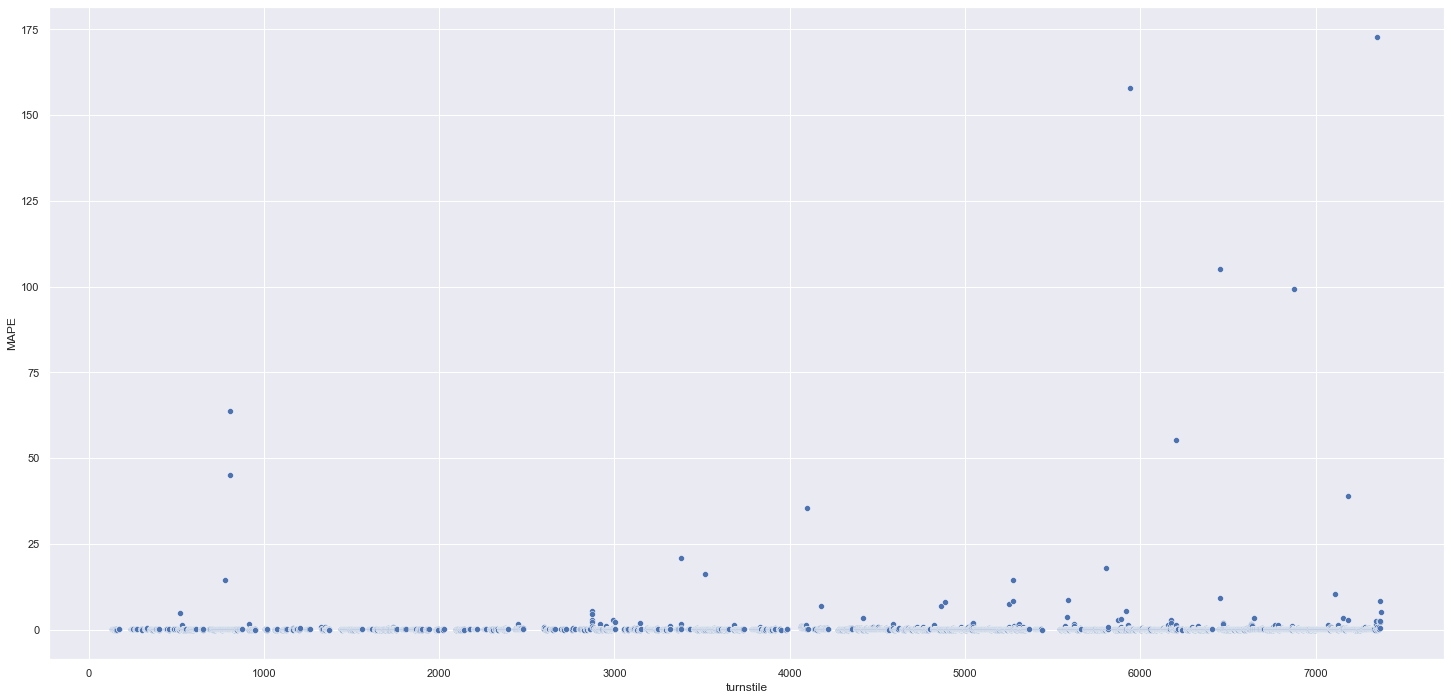

In [33]:
sns.scatterplot(x='turnstile', y='MAPE', data=df92);

## 9.2 - Total Performance

In [34]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'} )
df93

,Scenario,Values
0,predictions,255711424.843
1,worst_scenario,254906133.739
2,best_scenario,256516715.947


## 9.3 - Machine Learning Performance

In [35]:
df9['error'] = df9['flow'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['flow']

<AxesSubplot:xlabel='predictions', ylabel='error'>

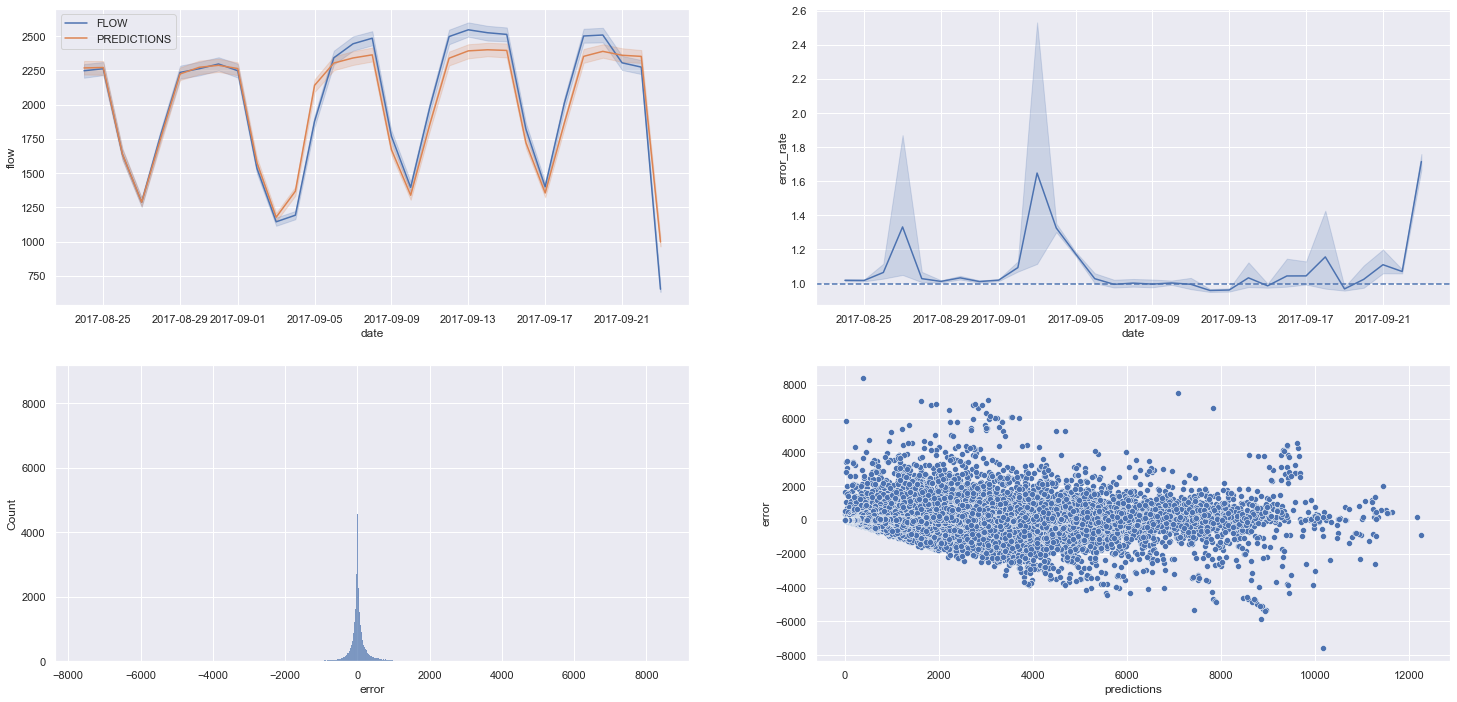

In [37]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='flow', data=df9, label='FLOW')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.histplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error'])

# CONCLUSION

In the first CRISP cycle the use of the 2015, 2016 and 2017 dataset provided relatively satisfatory results with Random Forest Regressor (MAE 184.198 / MAPE 0.178 / RMSE 395.452 / MPE -0.08291). Analysing the MAPE values in section 9.1 it can be observed that 14.33% of the turnstiles have values greater than 0.2. The top 100 values of MAPE have values weird time-series graphics as observed below:

<AxesSubplot:xlabel='date', ylabel='flow'>

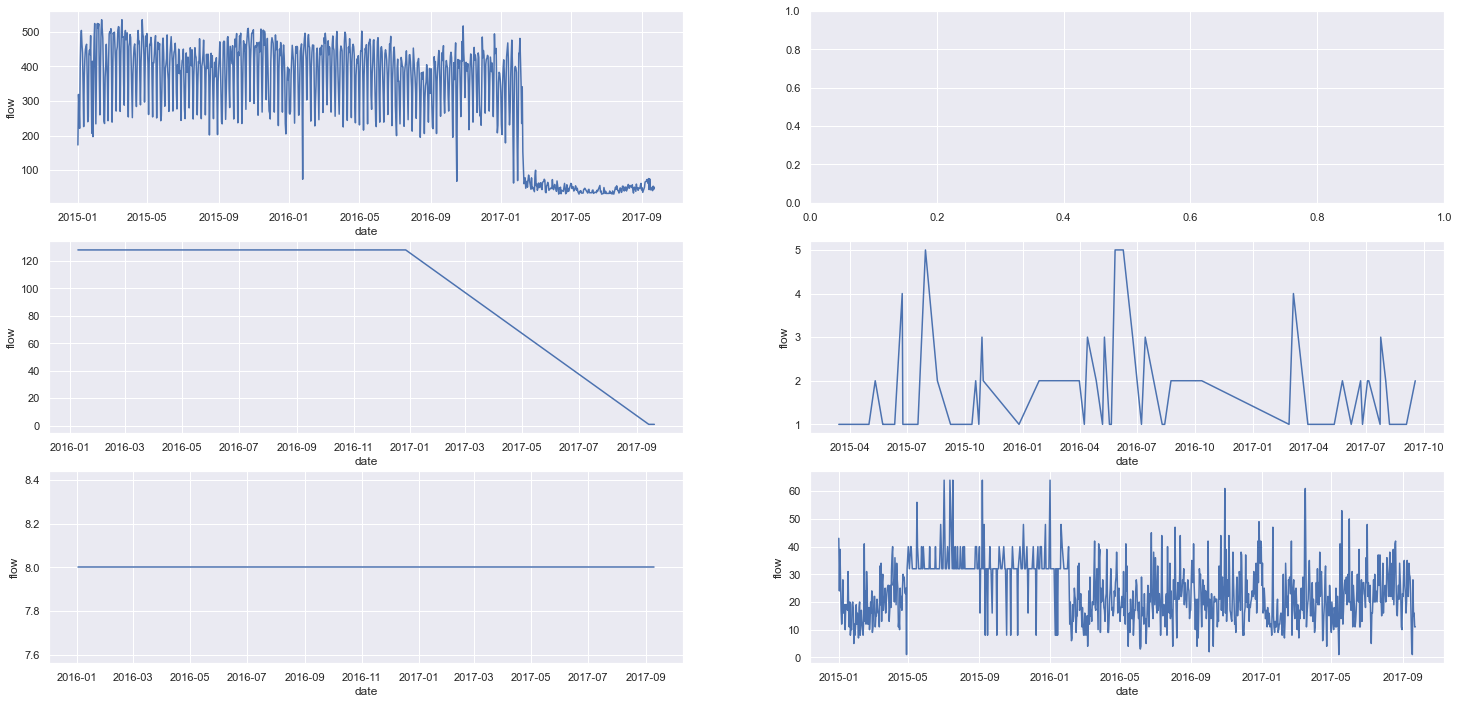

In [45]:
subplot(3,2,1)
aux = df4[df4['turnstile']==526]
sns.lineplot(x='date', y='flow', data=aux)

subplot(3,2,2)
aux = df4[df4['turnstile']==7593]
sns.lineplot(x='date', y='flow', data=aux)

subplot(3,2,3)
aux = df4[df4['turnstile']==5941]
sns.lineplot(x='date', y='flow', data=aux)

subplot(3,2,4)
aux = df4[df4['turnstile']==4096]
sns.lineplot(x='date', y='flow', data=aux)

subplot(3,2,5)
aux = df4[df4['turnstile']==4884]
sns.lineplot(x='date', y='flow', data=aux)

subplot(3,2,6)
aux = df4[df4['turnstile']==777]
sns.lineplot(x='date', y='flow', data=aux)